In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import auc, classification_report, roc_auc_score, f1_score, matthews_corrcoef, balanced_accuracy_score, r2_score , confusion_matrix, precision_score, recall_score

import pandas as pd
import numpy as np
import seaborn as sns

from my_util import *
from lime.lime.lime_tabular import LimeTabularExplainer

# from pyexplainer.pyexplainer_pyexplainer import PyExplainer
import matplotlib.pyplot as plt

import os, pickle, time, re, sys, operator
from datetime import datetime
from collections import Counter


sys.path.append(os.path.abspath('../pyexplainer'))
from pyexplainer_pyexplainer import *

from IPython.display import display

In [3]:
data_path = './dataset/'
result_dir = './eval_result/'
dump_dataframe_dir = './dump_df/'
pyExp_dir = './pyExplainer_obj/'
other_object_dir = './other_object/'
# proj_name = 'qt' # ['openstack','qt']

In [4]:
x_train,x_test,y_train ,y_test = prepare_data('openstack')
print(len(y_train),np.sum(y_train))
print(len(y_test),np.sum(y_test))

# display(x_train)
# display(x_test)

9246 980
3963 646


In [5]:
# op_py_exp = pickle.load(open(pyExp_dir+'openstack'+'_rulefit_crossoverinterpolation_'+'1e6973aee7137653c62dcef970b1e2527b50517d'+'.pkl','rb'))
# # lime_exp = pickle.load(open(pyExp_dir+'openstack'+'_lime_'+row_index+'.pkl','rb'))
# qt_py_exp = pickle.load(open(pyExp_dir+'qt'+'_rulefit_crossoverinterpolation_'+'f5dbc876378ae58a7bdfe1e9664fc81caca18dfb'+'.pkl','rb'))

# print(op_py_exp.keys())
# print(np.sum(op_py_exp['synthetic_predictions'])/len(op_py_exp['synthetic_predictions']))
# print(np.sum(qt_py_exp['synthetic_predictions'])/len(qt_py_exp['synthetic_predictions']))

In [6]:
# def test_lime(proj_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
#     all_eval_result = pd.DataFrame()
    
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
#         lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

#         # this data can be used for both local and global model
#         py_exp_synthetic_data = py_exp['synthetic_data'].values
#         # this data can be used with global model only
#         lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
#         # this data can be used with local model only
#         lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
#         display(X_explain)
#         display(lime_exp_synthetic_data[:5,:])
#         display(lime_exp_synthetic_data_local[:5,:])
        
#         break
        
# test_lime('openstack')

In [7]:
flip_sign_dict = {
    '<': '>=',
    '>': '<=',
    '=': '!=',
    '>=': '<',
    '<=': '>',
    '!=': '=='
}

'''
    input: rule (str)
'''
def flip_rule(rule):
    rule = re.sub(r'\b=\b',' = ',rule) # for LIME
#     rule = rule.replace('&','and') # for RuleFit
    found_rule = re.findall('.* <=? [a-zA-Z]+ <=? .*', rule) # for LIME
    ret = ''
    
    # for LIME that has condition like this: 0.53 < nref <= 0.83
    if len(found_rule) > 0:
        found_rule = found_rule[0]
    
        var_in_rule = re.findall('[a-zA-Z]+',found_rule)

        var_in_rule = var_in_rule[0]
        
        splitted_rule = found_rule.split(var_in_rule)
        splitted_rule[0] = splitted_rule[0] + var_in_rule # for left side
        splitted_rule[1] = var_in_rule + splitted_rule[1] # for right side
        combined_rule = splitted_rule[0] + ' or ' + splitted_rule[1]
        ret = flip_rule(combined_rule)
        
    else:
        for tok in rule.split():
            if tok in flip_sign_dict:
                ret = ret + flip_sign_dict[tok] + ' '
            else:
                ret = ret + tok + ' '
    return ret

def get_top_k_global_features(global_model, indep, top_k_global_feature_num = 5):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    top_k_global_features = list(global_feature_df['feature'])[:top_k_global_feature_num]

    return top_k_global_features
    
def sort_global_feature(global_model, indep):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    sorted_global_features = list(global_feature_df['feature'])

    return sorted_global_features

def get_rule_str_of_rulefit(local_rulefit_model):
    rule_df = local_rulefit_model.get_rules()
#     print(rule_df)
    top_k = 5
    top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False).head(top_k)
#     top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("coef", ascending=False).head(top_k)

    the_best_defective_rule_str = list(top_k_positive_rules['rule'])[0]
    
    return the_best_defective_rule_str

def get_rule_str_of_rulefit_new_version(local_rulefit_model):
    rule_df = local_rulefit_model.get_rules()
    rule_df =  rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False)
    
    rule_list = list(rule_df['rule'])
    dup_feature_in_rule = [] # true or false...
    
    for r in rule_list:
        var_in_rule = re.findall('[a-zA-Z]+', r)
        var_count = Counter(var_in_rule)
        max_count = max(list(var_count.values()))
        
        if max_count > 1:
            dup_feature_in_rule.append(True)
        else:
            dup_feature_in_rule.append(False)
           
    if False not in set(dup_feature_in_rule):
#         print('wtf')
        rule_df = rule_df.head(5)
        the_best_defective_rule_str = list(rule_df['rule'])[0]
        
    else:
        rule_df['contain_dup_var'] = dup_feature_in_rule    
        the_best_defective_rule_str = rule_df[rule_df['contain_dup_var']==False].iloc[0]['rule']
    
    return the_best_defective_rule_str

def aggregate_list(l):
    return np.mean(l), np.median(l)


In [8]:
# def test_new_rule_from_rulefit(proj_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
#     all_eval_result = pd.DataFrame()
    
#     c = 0
    
# #     py_exp_all_rules = []
# #     lime_all_rules = []
#     py_exp_all_vars = []
#     lime_all_vars = []
    
#     print('global feature feature importance ranking:')
#     print(sort_global_feature(global_model, indep))
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
#         py_exp_local_model = py_exp['local_model']
        
#         lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))
        
# #         py_exp_rule = get_rule_str_of_rulefit(py_exp_local_model)
#         py_exp_rule_new = get_rule_str_of_rulefit_new_version(py_exp_local_model)
#         lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

#         py_exp_pred = eval_rule(py_exp_rule_new, X_explain)[0]
#         lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

#         if py_exp_pred == 1:
#             py_exp_var_in_rule = list(set(re.findall('[a-zA-Z]+', py_exp_rule_new)))
#             py_exp_all_vars.extend(py_exp_var_in_rule)
#         if lime_pred == 1:
#             lime_var_in_rule = list(set(re.findall('[a-zA-Z]+', lime_the_best_defective_rule_str)))
#             lime_all_vars.extend(lime_var_in_rule)
            
# #         py_exp_all_rules.append(py_exp_rule_new)
# #         lime_all_rules.append(lime_the_best_defective_rule_str)
        
# #         eval_result = eval_rule(lime_the_best_defective_rule_str, X_explain)

# #         if eval_result[0]:
# #             c =c+1

    
# #     print(len(set(py_exp_all_rules)))
# #     print(len(set(lime_all_rules)))
    
#     print('pyExplainer var count')
#     print(Counter(py_exp_all_vars))
#     print('-'*100)
#     print('LIME var count')
#     print(Counter(lime_all_vars))
    
# print('openstack')
# test_new_rule_from_rulefit('openstack')
# print('*'*100)
# print('qt')
# test_new_rule_from_rulefit('qt')

In [9]:
def is_in_top_k_global_features(top_k_global_features, the_best_defective_rule_str):
    # remove numeric value
    new_the_best_defective_rule_str = re.sub('\d+','', the_best_defective_rule_str)

    # remove special characters
    new_the_best_defective_rule_str = re.sub('\W+',' ',new_the_best_defective_rule_str)
    splitted_rule = new_the_best_defective_rule_str.split()

    local_feature_count = 0
    
    found_features = set(splitted_rule).intersection(top_k_global_features)
    return list(found_features)

# def eval_rule(rule, X_explain):
#     var_in_rule = re.findall('[a-zA-Z]+',rule)
#     rule = rule.replace('&','and') # just for rulefit
#     rule = re.sub(r'\b=\b','==',rule)
# #             rule = rule.replace('=','==')

#     var_dict = {}

#     for var in var_in_rule:
#         var_dict[var] = float(X_explain[var])

#     eval_result = eval(rule,var_dict)
#     return eval_result

        
def prepare_data_for_testing(proj_name, global_model_name = 'RF'):
    global_model_name = global_model_name.upper()
    global_model = pickle.load(open(proj_name+'_'+global_model_name+'_global_model.pkl','rb'))

    correctly_predict_df = pd.read_csv(dump_dataframe_dir+proj_name+'_'+global_model_name+'_correctly_predict_as_defective.csv')
    correctly_predict_df = correctly_predict_df.set_index('commit_id')

    dep = 'defect'
    indep = correctly_predict_df.columns[:-3] # exclude the last 3 columns

    feature_df = correctly_predict_df.loc[:, indep]
    
    return global_model, correctly_predict_df, indep, dep, feature_df
    

# Global model evaluation

In [12]:
def get_prediction_result_df(proj_name, global_model_name):
    global_model_name = global_model_name.upper()
    if global_model_name not in ['RF','LR']:
        print('wrong global model name. the global model name must be RF or LR')
        return
    
    prediction_df_dir = dump_dataframe_dir+proj_name+'_'+global_model_name+'_prediction_result.csv'
    correctly_predict_df_dir = dump_dataframe_dir+proj_name+'_'+global_model_name+'_correctly_predict_as_defective.csv'
    
    if not os.path.exists(prediction_df_dir) or not os.path.exists(correctly_predict_df_dir):
        global_model = pickle.load(open(proj_name+'_'+global_model_name+'_global_model.pkl','rb'))

        pred = global_model.predict(x_test)
        defective_prob = global_model.predict_proba(x_test)[:,1]

        prediction_df = x_test.copy()
        prediction_df['pred'] = pred
        prediction_df['defective_prob'] = defective_prob
        prediction_df['defect'] = y_test

    #     print('AUC is',roc_auc_score(y_test, defective_prob))
        correctly_predict_df = prediction_df[(prediction_df['pred']==1) & (prediction_df['defect']==1)]

        print('total correct prediction: {}'.format(str(len(correctly_predict_df))))

        prediction_df.to_csv(prediction_df_dir)
        correctly_predict_df.to_csv(correctly_predict_df_dir)
    
    else:
        prediction_df = pd.read_csv(prediction_df_dir)
        correctly_predict_df = pd.read_csv(correctly_predict_df_dir)
        
        prediction_df = prediction_df.set_index('commit_id')
        correctly_predict_df = correctly_predict_df.set_index('commit_id')
        print('total correct prediction: {}'.format(str(len(correctly_predict_df))))
        
    return prediction_df, correctly_predict_df

def get_recall_at_k_percent_effort(percent_effort, result_df_arg, real_buggy_commits):
    cum_LOC_k_percent = (percent_effort/100)*result_df_arg.iloc[-1]['cum_LOC']
    buggy_line_k_percent =  result_df_arg[result_df_arg['cum_LOC'] <= cum_LOC_k_percent]
    buggy_commit = buggy_line_k_percent[buggy_line_k_percent['defect']==True]
    recall_k_percent_effort = len(buggy_commit)/float(len(real_buggy_commits))
    
    return recall_k_percent_effort

def eval_global_model(proj_name, prediction_df):
    ## since ld metric in openstack is removed by using autospearman, so this code is needed
    ## but this is not problem for qt
    
    if proj_name == 'openstack':
        x_train_original, x_test_original = prepare_data_all_metrics(proj_name, mode='all')
        prediction_df = prediction_df.copy()
#         print('add ld')
#         display(x_test_original['ld'])
        prediction_df['ld'] = list(x_test_original['ld'])
        
    prediction_df = prediction_df[['la','ld', 'pred', 'defective_prob' ,'defect']]
    prediction_df['LOC'] = prediction_df['la']+prediction_df['ld']
    
    
#     result_df['defect_density'] = result_df['defective_commit_prob']/result_df['LOC']
    prediction_df['defect_density'] = prediction_df['defective_prob']/prediction_df['LOC']
    prediction_df['actual_defect_density'] = prediction_df['defect']/prediction_df['LOC'] #defect density
    
    prediction_df = prediction_df.fillna(0)
    prediction_df = prediction_df.replace(np.inf, 0)
    
    prediction_df = prediction_df.sort_values(by='defect_density',ascending=False)
#     display(prediction_df.head())
#     display(np.sum(prediction_df[prediction_df['la']==0]['defect']))
    
    actual_result_df = prediction_df.sort_values(by='actual_defect_density',ascending=False)
    actual_worst_result_df = prediction_df.sort_values(by='actual_defect_density',ascending=True)

    prediction_df['cum_LOC'] = prediction_df['LOC'].cumsum()
    actual_result_df['cum_LOC'] = actual_result_df['LOC'].cumsum()
    actual_worst_result_df['cum_LOC'] = actual_worst_result_df['LOC'].cumsum()

    real_buggy_commits = prediction_df[prediction_df['defect'] == True]
    
#     display(prediction_df)
#     display(real_buggy_commits)
    
    
    AUC = roc_auc_score(prediction_df['defect'], prediction_df['defective_prob'])
    f1 = f1_score(prediction_df['defect'], prediction_df['pred'])
    
    ifa = real_buggy_commits.iloc[0]['cum_LOC']
#     print('ifa:',ifa)

    cum_LOC_20_percent = 0.2*prediction_df.iloc[-1]['cum_LOC']
    buggy_line_20_percent = prediction_df[prediction_df['cum_LOC'] <= cum_LOC_20_percent]
    buggy_commit = buggy_line_20_percent[buggy_line_20_percent['defect']==True]
    recall_20_percent_effort = len(buggy_commit)/float(len(real_buggy_commits))
    
    # find P_opt
    percent_effort_list = []
    predicted_recall_at_percent_effort_list = []
    actual_recall_at_percent_effort_list = []
    actual_worst_recall_at_percent_effort_list = []
    
    for percent_effort in np.arange(10,101,10):
        predicted_recall_k_percent_effort = get_recall_at_k_percent_effort(percent_effort, prediction_df, real_buggy_commits)
        actual_recall_k_percent_effort = get_recall_at_k_percent_effort(percent_effort, actual_result_df, real_buggy_commits)
        actual_worst_recall_k_percent_effort = get_recall_at_k_percent_effort(percent_effort, actual_worst_result_df, real_buggy_commits)
        
        percent_effort_list.append(percent_effort/100)
        
        predicted_recall_at_percent_effort_list.append(predicted_recall_k_percent_effort)
        actual_recall_at_percent_effort_list.append(actual_recall_k_percent_effort)
        actual_worst_recall_at_percent_effort_list.append(actual_worst_recall_k_percent_effort)

    p_opt = 1 - ((auc(percent_effort_list, actual_recall_at_percent_effort_list) - 
                 auc(percent_effort_list, predicted_recall_at_percent_effort_list)) /
                (auc(percent_effort_list, actual_recall_at_percent_effort_list) -
                auc(percent_effort_list, actual_worst_recall_at_percent_effort_list)))

    print('AUC: {}, F1: {}, IFA: {}, Recall@20%Effort: {}, Popt: {}'.format(AUC,f1,ifa,recall_20_percent_effort,p_opt))
    print(classification_report(prediction_df['defect'], prediction_df['pred']))
#     display(cum_LOC_20_percent)
#     display(buggy_line_20_percent)
# #     display(cum_LOC_20_percent)
#     display(buggy_commit)
#     print(len(real_buggy_commits))
#     display(recall_20_percent_effort)

def get_global_model_evaluation_result(proj_name):
    print('RF global model result')
    rf_prediction_df, rf_correctly_predict_df = get_prediction_result_df(proj_name, 'rf')
    eval_global_model(proj_name, rf_prediction_df)

    print('-'*100)
    
    print('LR global model result')
    lr_prediction_df, lr_correctly_predict_df = get_prediction_result_df(proj_name, 'lr')
    eval_global_model(proj_name, lr_prediction_df)

In [18]:
get_global_model_evaluation_result('openstack')

RF global model result
total correct prediction: 198
AUC: 0.7468482561455155, F1: 0.35515695067264574, IFA: 244, Recall@20%Effort: 0.5619195046439629, Popt: 0.8247763516141581
              precision    recall  f1-score   support

       False       0.87      0.92      0.89      3317
        True       0.42      0.31      0.36       646

    accuracy                           0.82      3963
   macro avg       0.65      0.61      0.62      3963
weighted avg       0.80      0.82      0.81      3963

----------------------------------------------------------------------------------------------------
LR global model result
total correct prediction: 376
AUC: 0.6641828240110286, F1: 0.3550519357884797, IFA: 39, Recall@20%Effort: 0.5386996904024768, Popt: 0.8251993000194437
              precision    recall  f1-score   support

       False       0.89      0.67      0.76      3317
        True       0.26      0.58      0.36       646

    accuracy                           0.66      3963
   m

In [19]:
get_global_model_evaluation_result('qt')

RF global model result
total correct prediction: 79
AUC: 0.7350656132213174, F1: 0.20954907161803715, IFA: 19, Recall@20%Effort: 0.8340336134453782, Popt: 0.9434782608695651
              precision    recall  f1-score   support

       False       0.95      0.97      0.96      7801
        True       0.28      0.17      0.21       476

    accuracy                           0.93      8277
   macro avg       0.62      0.57      0.59      8277
weighted avg       0.91      0.93      0.92      8277

----------------------------------------------------------------------------------------------------
LR global model result
total correct prediction: 255
AUC: 0.6445637221687803, F1: 0.15877957658779576, IFA: 7, Recall@20%Effort: 0.8172268907563025, Popt: 0.9454658385093166
              precision    recall  f1-score   support

       False       0.96      0.68      0.80      7801
        True       0.09      0.54      0.16       476

    accuracy                           0.67      8277
   mac

<ipython-input-17-a087943c281d>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['LOC'] = prediction_df['la']+prediction_df['ld']
<ipython-input-17-a087943c281d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['defect_density'] = prediction_df['defective_prob']/prediction_df['LOC']
<ipython-input-17-a087943c281d>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

# RQ1 evaluation

In [98]:
# def check_LIME_generated_instances(proj_name, global_model_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)
#     all_eval_result = pd.DataFrame()
    
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])
#         lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

#         # this data can be used with global model only
#         lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        
#         lime_exp_local_model = lime_exp['local_model']


#         lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
# #         lime_exp_local_pred = np.round(lime_exp_local_pred)

#         total_defect =  np.sum(lime_exp_global_pred)
#         total_inst = len(lime_exp_global_pred)
#         lime_exp_def_pred_ratio = total_defect/total_inst

#         print(total_defect, total_inst, lime_exp_def_pred_ratio)
# #         print(np.sum(py_exp_global_pred), len(py_exp_global_pred), np.sum(lime_exp_global_pred), len(lime_exp_global_pred))
# #         py_exp_serie = pd.Series(data=[proj_name, row_index, 'pyExplainer',
# #                                        py_exp_dist_med, py_exp_def_pred_ratio])
# #         lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
# #                                          lime_exp_dist_med, lime_exp_def_pred_ratio])
        
# #         all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
# #         all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)

In [20]:
# check_LIME_generated_instances('openstack')

In [21]:
# check_LIME_generated_instances('qt')

In [22]:
def rq1_eval(proj_name, global_model_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+row_index+'.pkl','rb'))
        py_exp = exp_obj['pyExplainer']
        lime_exp = exp_obj['LIME']

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_global_pred = global_model.predict(py_exp_synthetic_data)

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
#         lime_exp_local_pred = np.round(lime_exp_local_pred)

        py_exp_dist = euclidean_distances(X_explain.values, py_exp_synthetic_data)
        lime_dist = euclidean_distances(X_explain.values, lime_exp_synthetic_data)

        py_exp_dist_mean, py_exp_dist_med = aggregate_list(py_exp_dist)
        lime_exp_dist_mean, lime_exp_dist_med = aggregate_list(lime_dist)

        py_exp_def_pred_ratio = np.sum(py_exp_global_pred)/len(py_exp_global_pred)
        lime_exp_def_pred_ratio = np.sum(lime_exp_global_pred)/len(lime_exp_global_pred)

#         print(np.sum(py_exp_global_pred), len(py_exp_global_pred), np.sum(lime_exp_global_pred), len(lime_exp_global_pred))
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'pyExplainer',
                                       py_exp_dist_med, py_exp_def_pred_ratio])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                         lime_exp_dist_med, lime_exp_def_pred_ratio])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
#         print(py_exp_def_pred_ratio, lime_exp_def_pred_ratio)
#         break
    all_eval_result.columns =['project', 'commit id', 'method', 'euc_dist_med', 'defective_generated_instance_ratio']
    
# # #     display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ1_'+proj_name+'_'+global_model_name+'.csv',index=False)
    print('finished RQ1 of',proj_name,', globla model is',global_model_name)
    
# rq1_eval('openstack') 

In [24]:
rq1_eval('openstack', 'RF')
rq1_eval('qt', 'RF')

finished RQ1 of openstack , globla model is RF
finished RQ1 of qt , globla model is RF


In [25]:
rq1_eval('openstack', 'LR')
rq1_eval('qt', 'LR')

finished RQ1 of openstack , globla model is LR
finished RQ1 of qt , globla model is LR


In [223]:
def show_rq1_eval_result():
    openstack_rf = pd.read_csv('./eval_result/RQ1_openstack_RF.csv')
    qt_rf = pd.read_csv('./eval_result/RQ1_qt_RF.csv')
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./eval_result/RQ1_openstack_LR.csv')
    qt_lr = pd.read_csv('./eval_result/RQ1_qt_LR.csv')
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

    fig, axs = plt.subplots(1,2, figsize=(10,6))

    axs[0].set_title('RF')
    axs[1].set_title('LR')
    
    axs[0].set(ylim=(0, 5000))
#     axs[1,0].set(ylim=(0, 1))
    axs[1].set(ylim=(0, 5000))
#     axs[1,1].set(ylim=(0, 1))
    
#     plt.ylim(0,5000)
    sns.boxplot(data=result_rf, x='project', y='euc_dist_med', hue='method', ax=axs[0])
#     plt.ylim(0,1)
#     sns.boxplot(data=result_rf, x='project', y='defective_generated_instance_ratio', hue='method', ax=axs[1,0])
#     plt.ylim(0,5000)
    sns.boxplot(data=result_lr, x='project', y='euc_dist_med', hue='method', ax=axs[1])
#     plt.ylim(0,1)
#     sns.boxplot(data=result_lr, x='project', y='defective_generated_instance_ratio', hue='method', ax=axs[1,1])
    
    plt.show()

    display(all_result.groupby(['global_model', 'project', 'method']).describe())
    
    result_rf.to_csv('./eval_result/RQ1_RF.csv',index=False)
    result_lr.to_csv('./eval_result/RQ1_LR.csv',index=False)
    all_result.to_csv('./eval_result/RQ1.csv',index=False)
    
    fig.savefig('./eval_result/figures/RQ1.png')
    
#     display(all_result)

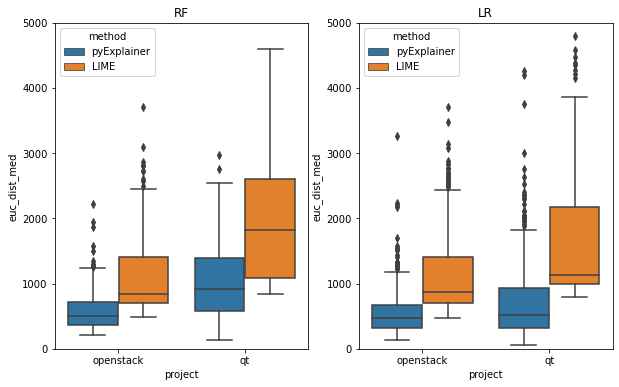

euc_dist_med                            \
                                          count         mean          std   
global_model project   method                                               
LR           openstack LIME               376.0  1131.262558   618.026586   
                       pyExplainer        376.0   557.807385   362.146216   
             qt        LIME               255.0  1710.479949  1179.979075   
                       pyExplainer        255.0   811.010560  1017.593081   
RF           openstack LIME               198.0  1127.613198   623.720753   
                       pyExplainer        198.0   591.730160   336.210659   
             qt        LIME                79.0  1981.142021   992.506462   
                       pyExplainer         79.0  1073.430037   658.951800   

                                                                          \
                                           min          25%          50%   
global_model project   method                                              
LR           openstack LIME         477.756571   701.172394   870.391645   
                       pyExplainer  138.915781   312.663098   464.889745   
             qt        LIME         793.941497   991.287738  1138.732355   
                       pyExplainer   56.939860   319.096248   519.294034   
RF           openstack LIME         480.403424   706.994530   841.419710   
                       pyExplainer  208.965221   363.540465   499.514998   
             qt        LIME         841.474520  1082.522918  1825.047204   
                       pyExplainer  142.504855   586.150375   923.460322   

                                                               \
                                            75%           max   
global_model project   method                                   
LR           openstack LIME         1406.863042   3714.300936   
                       pyExplainer   668.952822   3265.423908   
             qt        LIME         2175.935989  13066.498777   
                       pyExplainer   939.178532  12696.966184   
RF           openstack LIME         1413.531171   3706.934900   
                       pyExplainer   718.352814   2221.477801   
             qt        LIME         2603.049893   4588.606492   
                       pyExplainer  1386.965269   2972.080245   

                                   defective_generated_instance_ratio  \
                                                                count   
global_model project   method                                           
LR           openstack LIME                                     376.0   
                       pyExplainer                              376.0   
             qt        LIME                                     255.0   
                       pyExplainer                              255.0   
RF           openstack LIME                                     198.0   
                       pyExplainer                              198.0   
             qt        LIME                                      79.0   
                       pyExplainer                               79.0   

                                                                            \
                                        mean       std       min       25%   
global_model project   method                                                
LR           openstack LIME         0.597434  0.006264  0.576400  0.593000   
                       pyExplainer  0.687295  0.167879  0.170982  0.591065   
             qt        LIME         0.596206  0.006805  0.572800  0.591800   
                       pyExplainer  0.716454  0.169285  0.183036  0.635175   
RF           openstack LIME         0.165280  0.004570  0.154600  0.161850   
                       pyExplainer  0.560800  0.094219  0.203125  0.496987   
             qt        LIME         0.135856  0.004667  0.123000  0.133100   
                       pyExplainer  0.485236  0.05

In [224]:
show_rq1_eval_result()

,project,commit id,method,euc_dist_med,defective_generated_instance_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,pyExplainer,349.245008,0.454018
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,539.434323,0.169000
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,pyExplainer,498.606153,0.713060
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,1400.589845,0.166800
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,pyExplainer,233.375005,0.544196


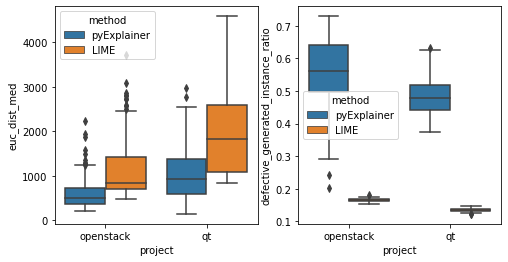

euc_dist_med                                       \
                             count         mean         std         min   
project   method                                                          
openstack LIME               198.0  1127.613198  623.720753  480.403424   
          pyExplainer        198.0   591.730160  336.210659  208.965221   
qt        LIME                79.0  1981.142021  992.506462  841.474520   
          pyExplainer         79.0  1073.430037  658.951800  142.504855   

                                                                           \
                               25%          50%          75%          max   
project   method                                                            
openstack LIME          706.994530   841.419710  1413.531171  3706.934900   
          pyExplainer   363.540465   499.514998   718.352814  2221.477801   
qt        LIME         1082.522918  1825.047204  2603.049893  4588.606492   
          pyExplainer   586.150375   923.460322  1386.965269  2972.080245   

                      defective_generated_instance_ratio                      \
                                                   count      mean       std   
project   method                                                               
openstack LIME                                     198.0  0.165280  0.004570   
          pyExplainer                              198.0  0.560800  0.094219   
qt        LIME                                      79.0  0.135856  0.004667   
          pyExplainer                               79.0  0.485236  0.058970   

                                                                         
                            min       25%       50%       75%       max  
project   method                                                         
openstack LIME         0.154600  0.161850  0.165200  0.168400  0.180800  
          pyExplainer  0.203125  0.496987  0.560373  0.641589  0.729038  
qt        LIME         0.123000  0.133100  0.136200  0.139000  0.147400  
          pyExplainer  0.375446  0.442857  0.479464  0.517931  0.630601

In [47]:
show_rq1_eval_result('rf')

,project,commit id,method,euc_dist_med,defective_generated_instance_ratio
0,openstack,71f2184c617123b90f8e911056f23e3346c7c592,pyExplainer,201.826099,0.558753
1,openstack,71f2184c617123b90f8e911056f23e3346c7c592,LIME,517.262852,0.595600
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,pyExplainer,594.107640,0.855357
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,1393.158004,0.586400
4,openstack,ef8017ff798c2a1bc548af6f0356b1aab3cfb0e2,pyExplainer,297.858818,0.779392


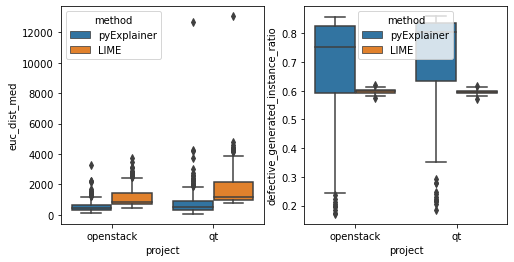

euc_dist_med                                        \
                             count         mean          std         min   
project   method                                                           
openstack LIME               376.0  1131.262558   618.026586  477.756571   
          pyExplainer        376.0   557.807385   362.146216  138.915781   
qt        LIME               255.0  1710.479949  1179.979075  793.941497   
          pyExplainer        255.0   811.010560  1017.593081   56.939860   

                                                                           \
                              25%          50%          75%           max   
project   method                                                            
openstack LIME         701.172394   870.391645  1406.863042   3714.300936   
          pyExplainer  312.663098   464.889745   668.952822   3265.423908   
qt        LIME         991.287738  1138.732355  2175.935989  13066.498777   
          pyExplainer  319.096248   519.294034   939.178532  12696.966184   

                      defective_generated_instance_ratio                      \
                                                   count      mean       std   
project   method                                                               
openstack LIME                                     376.0  0.597434  0.006264   
          pyExplainer                              376.0  0.687295  0.167879   
qt        LIME                                     255.0  0.596206  0.006805   
          pyExplainer                              255.0  0.716454  0.169285   

                                                                         
                            min       25%       50%       75%       max  
project   method                                                         
openstack LIME         0.576400  0.593000  0.597400  0.602400  0.620000  
          pyExplainer  0.170982  0.591065  0.750934  0.824219  0.855357  
qt        LIME         0.572800  0.591800  0.596400  0.600600  0.616800  
          pyExplainer  0.183036  0.635175  0.804464  0.835268  0.859375

In [48]:
show_rq1_eval_result('lr')

# RQ2 evaluation

In [29]:
# def check_pyExp_prediction(proj_name,global_model_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name,global_model_name)
#     all_eval_result = pd.DataFrame()

#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
#         # this data can be used for both local and global model
#         py_exp_synthetic_data = py_exp['synthetic_data'].values
#         py_exp_local_model = py_exp['local_model']
#         py_exp_global_pred = global_model.predict(py_exp_synthetic_data) 
#         py_exp_local_prob = py_exp_local_model.predict_proba(py_exp_synthetic_data)[:,1]
#         py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
        
#         tn, fp, fn, tp = confusion_matrix(py_exp_global_pred, py_exp_local_pred).ravel()
        
#         print('total prediction:',len(py_exp_global_pred))
#         print('TN:',tn,'FP:', fp,'FN:', fn,'TP:', tp)
# #         py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

# #         pred_df = pd.DataFrame()
# #         pred_df['label'] = py_exp_global_pred
# #         pred_df['prob'] = py_exp_local_prob
# #         pred_df['pred'] = py_exp_local_pred
        
# #         true_pred_df = pred_df[pred_df['label']==True]
# #         print('total prediction:',len(pred_df))
# #         print('total global correct prediction:', len(true_pred_df))
# #         display(true_pred_df)
        
#         print('-'*100)
        
#         if i > 10:
#             break
# #         py_exp_auc = roc_auc_score(py_exp_global_pred, py_exp_local_prob)
# #         py_exp_f1 = f1_score(py_exp_global_pred, py_exp_local_pred)
# #         py_exp_mcc = matthews_corrcoef(py_exp_global_pred, py_exp_local_pred)
# #         py_exp_bal_acc = balanced_accuracy_score(py_exp_global_pred, py_exp_local_pred)
        
        
    

In [110]:
# check_pyExp_prediction('openstack')

total prediction: 2240
TN: 1166 FP: 48 FN: 70 TP: 956
----------------------------------------------------------------------------------------------------
total prediction: 2098
TN: 578 FP: 15 FN: 3 TP: 1502
----------------------------------------------------------------------------------------------------
total prediction: 2240
TN: 1005 FP: 51 FN: 73 TP: 1111
----------------------------------------------------------------------------------------------------
total prediction: 2213
TN: 987 FP: 76 FN: 51 TP: 1099
----------------------------------------------------------------------------------------------------
total prediction: 2124
TN: 760 FP: 41 FN: 22 TP: 1301
----------------------------------------------------------------------------------------------------
total prediction: 2189
TN: 788 FP: 71 FN: 60 TP: 1270
----------------------------------------------------------------------------------------------------
total prediction: 2217
TN: 916 FP: 19 FN: 18 TP: 1264
----------------

In [111]:
# check_pyExp_prediction('qt')

total prediction: 2186
TN: 1204 FP: 24 FN: 22 TP: 936
----------------------------------------------------------------------------------------------------
total prediction: 2240
TN: 1127 FP: 20 FN: 21 TP: 1072
----------------------------------------------------------------------------------------------------
total prediction: 2207
TN: 1190 FP: 17 FN: 16 TP: 984
----------------------------------------------------------------------------------------------------
total prediction: 2152
TN: 1041 FP: 27 FN: 18 TP: 1066
----------------------------------------------------------------------------------------------------
total prediction: 2092
TN: 797 FP: 48 FN: 38 TP: 1209
----------------------------------------------------------------------------------------------------
total prediction: 2193
TN: 1078 FP: 17 FN: 15 TP: 1083
----------------------------------------------------------------------------------------------------
total prediction: 2240
TN: 1127 FP: 16 FN: 22 TP: 1075
------------

In [240]:
def rq2_eval(proj_name, global_model_name):
    global_model_name = global_model_name.upper()
    
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)
    all_eval_result = pd.DataFrame()

#     pyexp_pred_df = pd.DataFrame()
#     lime_pred_df = pd.DataFrame()
    
    pyexp_label, pyexp_prob = [],[]
    lime_label, lime_prob = [],[]
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+row_index+'.pkl','rb'))
        py_exp = exp_obj['pyExplainer']
        lime_exp = exp_obj['LIME']

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        # this data can be used with local model only
        lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_global_pred = global_model.predict(py_exp_synthetic_data) 
        py_exp_local_prob = py_exp_local_model.predict_proba(py_exp_synthetic_data)[:,1]
        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
#         py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
        lime_exp_local_prob = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        lime_exp_local_pred = np.round(lime_exp_local_prob)
        
        pyexp_label.extend(list(py_exp_global_pred))
        pyexp_prob.extend(list(py_exp_local_prob))
        
        lime_label.extend(list(lime_exp_global_pred))
        lime_prob.extend(list(lime_exp_local_prob))
        
        
        py_exp_auc = roc_auc_score(py_exp_global_pred, py_exp_local_prob)
        py_exp_f1 = f1_score(py_exp_global_pred, py_exp_local_pred)
#         py_exp_mcc = matthews_corrcoef(py_exp_global_pred, py_exp_local_pred)
#         py_exp_bal_acc = balanced_accuracy_score(py_exp_global_pred, py_exp_local_pred)
        
        lime_auc = roc_auc_score(lime_exp_global_pred, lime_exp_local_prob)
        lime_f1 = f1_score(lime_exp_global_pred, lime_exp_local_pred)
#         lime_mcc = matthews_corrcoef(lime_exp_global_pred, lime_exp_local_pred)
#         lime_bal_acc = balanced_accuracy_score(lime_exp_global_pred, lime_exp_local_pred)

        py_exp_serie = pd.Series(data=[proj_name, row_index, 'pyExplainer',
                                        py_exp_auc, py_exp_f1])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                           lime_auc, lime_f1])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
#         break

    pred_df = pd.DataFrame()
    
    all_tech = ['pyExplainer']*len(pyexp_label) + ['LIME']*len(lime_label)
    
    pred_df['technique'] = all_tech
    pred_df['label'] = pyexp_label+lime_label
    pred_df['prob'] = pyexp_prob+lime_prob
    pred_df['project'] = proj_name
    
    all_eval_result.columns = ['project', 'commit id', 'method', 'AUC', 'F1']

#     display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ2_'+proj_name+'_'+global_model_name+'_global_vs_local_synt_pred.csv',index=False)
    pred_df.to_csv(result_dir+'RQ2_'+proj_name+'_'+global_model_name+'_probability_distribution.csv',index=False)
    print('finished RQ2 of',proj_name)

In [241]:
rq2_eval('openstack','RF')
rq2_eval('qt','RF')

finished RQ2 of openstack
finished RQ2 of qt


In [242]:
rq2_eval('openstack','lr')
rq2_eval('qt','lr')

finished RQ2 of openstack
finished RQ2 of qt


In [232]:
def show_rq2_eval_result():
    openstack_rf = pd.read_csv('./eval_result/RQ2_openstack_RF_global_vs_local_synt_pred.csv')
    qt_rf = pd.read_csv('./eval_result/RQ2_qt_RF_global_vs_local_synt_pred.csv')
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./eval_result/RQ2_openstack_LR_global_vs_local_synt_pred.csv')
    qt_lr = pd.read_csv('./eval_result/RQ2_qt_LR_global_vs_local_synt_pred.csv')
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

    fig, axs = plt.subplots(2,2, figsize=(10,10))

    axs[0,0].set_title('RF')
    axs[0,1].set_title('LR')
    
    axs[0,0].set_ylim([0, 1])
    axs[0,1].set_ylim([0, 1]) 
    axs[1,0].set_ylim([0, 1])
    axs[1,1].set_ylim([0, 1])

    sns.boxplot(data=result_rf, x='project', y='AUC', hue='method', ax=axs[0,0])
    sns.boxplot(data=result_rf, x='project', y='F1', hue='method', ax=axs[1,0])
    sns.boxplot(data=result_lr, x='project', y='AUC', hue='method', ax=axs[0,1])
    sns.boxplot(data=result_lr, x='project', y='F1', hue='method', ax=axs[1,1])


    plt.show()

    pd.set_option("max_columns", 40)
    display(all_result.groupby(['global_model', 'project','method']).describe())
    
    result_rf.to_csv('./eval_result/RQ2_RF_prediction.csv',index=False)
    result_lr.to_csv('./eval_result/RQ2_LR_prediction.csv',index=False)
    all_result.to_csv('./eval_result/RQ2_prediction.csv',index=False)
    
    fig.savefig('./eval_result/figures/RQ2_prediction.png')
#     print('openstack result')
#     display(openstack_result_df.groupby('method').describe())
#     print('qt result')
#     display(qt_result_df.groupby('method').describe())

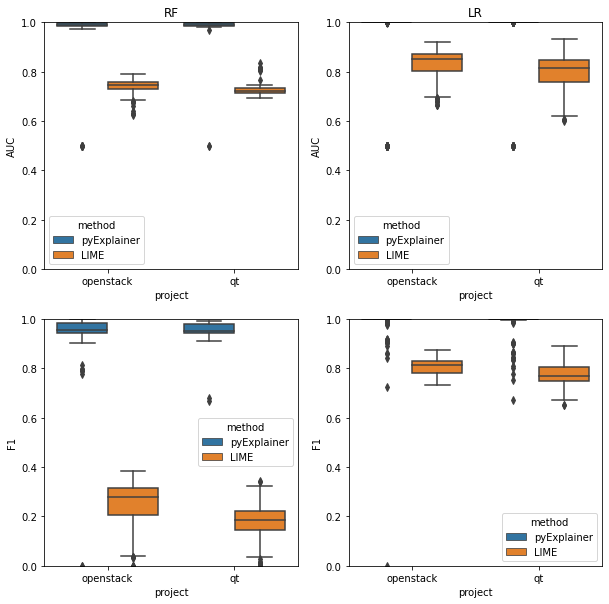

AUC                                \
                                    count      mean       std       min   
global_model project   method                                             
LR           openstack LIME         376.0  0.829845  0.054818  0.665162   
                       pyExplainer  376.0  0.965342  0.127000  0.500000   
             qt        LIME         255.0  0.799339  0.073578  0.599662   
                       pyExplainer  255.0  0.962703  0.131546  0.500000   
RF           openstack LIME         198.0  0.739566  0.029421  0.623621   
                       pyExplainer  198.0  0.970641  0.097037  0.500000   
             qt        LIME          79.0  0.728769  0.031849  0.693537   
                       pyExplainer   79.0  0.978399  0.077853  0.500000   

                                                                            \
                                         25%       50%       75%       max   
global_model project   method                                                
LR           openstack LIME         0.801032  0.849540  0.871259  0.918184   
                       pyExplainer  0.999999  1.000000  1.000000  1.000000   
             qt        LIME         0.756315  0.815708  0.847866  0.932132   
                       pyExplainer  0.999942  1.000000  1.000000  1.000000   
RF           openstack LIME         0.727860  0.746571  0.757864  0.791661   
                       pyExplainer  0.984893  0.987770  0.997650  1.000000   
             qt        LIME         0.712514  0.720373  0.732195  0.835871   
                       pyExplainer  0.986425  0.989037  0.997969  0.999191   

                                       F1                                \
                                    count      mean       std       min   
global_model project   method                                             
LR           openstack LIME         376.0  0.805110  0.030884  0.732030   
                       pyExplainer  376.0  0.988979  0.058272  0.000000   
             qt        LIME         255.0  0.775945  0.045094  0.650254   
                       pyExplainer  255.0  0.987397  0.044310  0.671770   
RF           openstack LIME         198.0  0.249181  0.087802  0.000000   
                       pyExplainer  198.0  0.944699  0.102566  0.000000   
             qt        LIME          79.0  0.168112  0.088696  0.000000   
                       pyExplainer   79.0  0.948696  0.049454  0.667460   

                                                                            
                                         25%       50%       75%       max  
global_model project   method                                               
LR           openstack LIME         0.780089  0.811333  0.830309  0.875282  
                       pyExplainer  0.999201  1.000000  1.000000  1.000000  
             qt        LIME         0.746965  0.767388  0.804211  0.889723  
                       pyExplainer  0.998394  1.000000  1.000000  1.000000  
RF           openstack LIME         0.203805  0.277810  0.314145  0.385425  
                       pyExplainer  0.941006  0.955757  0.981835  1.000000  
             qt        LIME         0.145653  0.185090  0.220874  0.344488  
                       pyExplainer  0.940376  0.951140  0.979230  0.988722

In [233]:
show_rq2_eval_result()

In [243]:
def show_rq2_prob_distribution():
    
    d = {True: 'DEFECT', False: 'CLEAN'}


    openstack_rf = pd.read_csv('./eval_result/RQ2_openstack_RF_probability_distribution.csv')
    qt_rf = pd.read_csv('./eval_result/RQ2_qt_RF_probability_distribution.csv')
    
    mask = openstack_rf.applymap(type) != bool
    openstack_rf = openstack_rf.where(mask, openstack_rf.replace(d))
    qt_rf = qt_rf.where(mask, qt_rf.replace(d))
    
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./eval_result/RQ2_openstack_LR_probability_distribution.csv')
    qt_lr = pd.read_csv('./eval_result/RQ2_qt_LR_probability_distribution.csv')
    
    openstack_lr = openstack_lr.where(mask, openstack_lr.replace(d))
    qt_lr = qt_lr.where(mask, qt_lr.replace(d))
    
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

#     display(all_result.head())
    fig, axs = plt.subplots(2,2, figsize=(10,10))

#     axs[0,0].set_title('RF')
#     axs[0,1].set_title('LR')
    
    axs[0,0].set_ylim([0, 1])
    axs[0,1].set_ylim([0, 1]) 
    axs[1,0].set_ylim([0, 1])
    axs[1,1].set_ylim([0, 1])
    
    sns.boxplot(data=openstack_rf, x='technique', y='prob', hue='label' , ax=axs[0,0])
    sns.boxplot(data=qt_rf,  x='technique', y='prob', hue='label' , ax=axs[1,0])
    sns.boxplot(data=openstack_lr,  x='technique', y='prob', hue='label' , ax=axs[0,1])
    sns.boxplot(data=qt_lr,  x='technique', y='prob', hue='label' , ax=axs[1,1], palette=['darkorange','royalblue'])
    
    axs[0,0].axhline(0.5, ls='--')
    axs[0,1].axhline(0.5, ls='--')
    axs[1,0].axhline(0.5, ls='--')
    axs[1,1].axhline(0.5, ls='--')
    
    cols = ['Global model: RF', 'Global model: LR']
    rows = ['Openstack','Qt']

    plt.setp(axs.flat, xlabel='Technique', ylabel='Probability')

    pad = 5 # in points

    for ax, col in zip(axs[0], cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

    for ax, row in zip(axs[:,0], rows):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')
    
    plt.show()
    
    result_rf.to_csv('./eval_result/RQ2_RF_prediction_prob.csv',index=False)
    result_lr.to_csv('./eval_result/RQ2_LR_prediction_prob.csv',index=False)
    all_result.to_csv('./eval_result/RQ2_prediction_prob.csv',index=False)
    
    fig.savefig('./eval_result/figures/RQ2_prediction_prob.png')

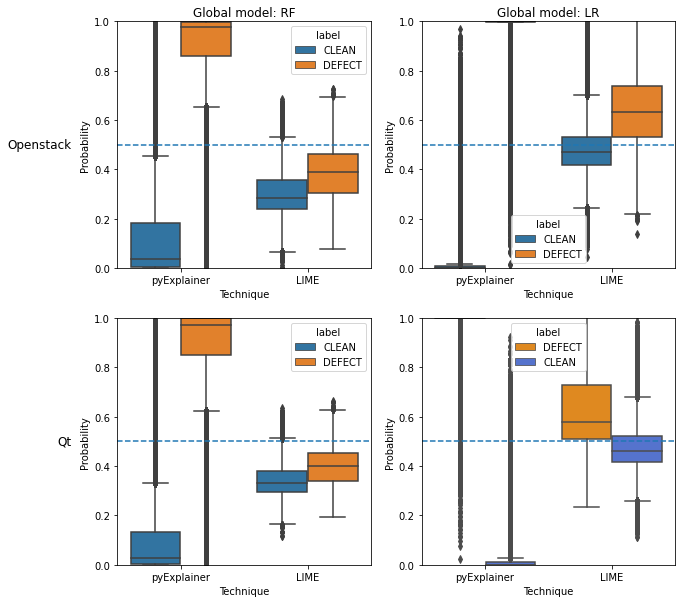

In [244]:
show_rq2_prob_distribution()

In [29]:
# def raname_files(proj_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name = 'RF')
#     all_eval_result = pd.DataFrame()
#     x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')

#     for i in range(0,len(x_test)):
#         X_explain = x_test.iloc[[i]]

#         row_index = str(X_explain.index[0])
        
# #         old_filename = pyExp_dir+proj_name+'_all_explainer_'+row_index+'.pkl'
#         new_filename = pyExp_dir+proj_name+'_RF_all_explainer_'+row_index+'.pkl'
#         exp_obj = pickle.load(open(new_filename,'rb'))
        
#         # new filename: pyExp_dir+proj_name+'_RF_all_explainer_'+row_index+'.pkl'
# #         print(exp_obj.keys())
        
# #         pickle_file = pickle.load(open(pyExp_dir+proj_name+'_LR_all_explainer_'+row_index+'.pkl','rb'))
# #         os.rename(old_filename, new_filename)
        
#         break

#     print('finished')

In [31]:
# raname_files('openstack')
# raname_files('qt')

In [174]:
# roc_auc_score

# f1_score

# balanced_accuracy_score

# precision_score

# recall_score

def classification_eval(prob, pred, label):
    auc = roc_auc_score(label,prob)
    f1 = f1_score(label,pred)
    bal_acc = balanced_accuracy_score(label,pred)
    prec = precision_score(label,pred)
    rec = recall_score(label,pred)
    
    return auc, bal_acc, prec, rec, f1

def rq2_2_eval(proj_name, global_model_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
#     ground_truth = np.ones(len(feature_df)).astype(bool)
    
    categorical_features_list = [6]
    
    class_label = ['clean', 'defect']
    
#     lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
#                                       feature_names=indep, class_names=class_label,
#                                       random_state=0)

    
    py_exp_prob, py_exp_pred = [], []
    lime_prob, lime_pred = [], []
    
    local_pred_df = pd.DataFrame()
    
    for i in range(0,len(x_test)):
        X_explain = x_test.iloc[[i]]

        row_index = str(X_explain.index[0])

        exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+row_index+'.pkl','rb'))
#         print(exp_obj.keys())
        py_exp = exp_obj['pyExplainer']
        lime_exp = exp_obj['LIME']

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        selected_feature_indices = lime_exp['selected_feature_indeces']
        lime_input = np.ones((1,len(selected_feature_indices)))

        py_exp_local_prob = py_exp_local_model.predict_proba(X_explain.values)[:,1][0]
        py_exp_local_pred = py_exp_local_model.predict(X_explain.values)[0]

        lime_exp_local_prob = lime_exp_local_model.predict(lime_input)[0]
        lime_exp_local_pred = np.round(lime_exp_local_prob).astype(bool)

#         print(py_exp_local_prob, py_exp_local_pred, lime_exp_local_prob, lime_exp_local_pred)
#         print('predict finished')
        
        py_exp_prob.append(py_exp_local_prob)
        py_exp_pred.append(py_exp_local_pred)
        
        
        lime_prob.append(lime_exp_local_prob)
        lime_pred.append(lime_exp_local_pred)
#         print(py_exp_local_prob, py_exp_local_pred, lime_exp_local_prob, lime_exp_local_pred)
#         print(py_exp_pred, lime_pred)
        
#         if py_exp_pred == 1:
#             py_exp_pred_count = py_exp_pred_count +1
#         if lime_pred == 1:
#             lime_pred_count = lime_pred_count + 1

#         del py_exp, lime_exp, py_exp_local_model, lime_exp_local_model
#         print(py_exp_local_pred, lime_exp_local_pred)
#         print('finished {}/{} instances'.format(i, len(x_test)))
#         break
  
#         if i > 5:
#             break
            
    local_pred_df['ground_truth'] = list(y_test)
    local_pred_df['pyExplainer_prob'] = py_exp_prob
    local_pred_df['pyExplainer_pred'] = py_exp_pred
    local_pred_df['lime_prob'] = lime_prob
    local_pred_df['lime_pred'] = lime_pred
    
    local_pred_df.to_csv(dump_dataframe_dir+proj_name+'_'+global_model_name+'_local_prediction_of_actual_test_data.csv',index=False)
    
    print('pyExplainer')
    tn, fp, fn, tp = confusion_matrix(y_test, py_exp_pred).ravel()
    print(tn, fp, fn, tp)
    auc, bal_acc, prec, rec, f1 = classification_eval(py_exp_prob, py_exp_pred, y_test)
    print(auc, bal_acc, prec, rec, f1)
    
    print('LIME')
    tn, fp, fn, tp = confusion_matrix(y_test, lime_pred).ravel()
    print(tn, fp, fn, tp)
    auc, bal_acc, prec, rec, f1 = classification_eval(lime_prob, lime_pred, y_test)
    print(auc, bal_acc, prec, rec, f1)
    
    print('finished RQ2.2 of',proj_name)

In [175]:
start = time.time()
rq2_2_eval('openstack', 'RF')
end = time.time()
print('time spent {} secs'.format(end-start))

pyExplainer
2945 372 437 209
0.6964534889690132 0.6056899395272127 0.35972461273666095 0.3235294117647059 0.3406682966585167
LIME
2781 536 317 329
0.760267726721617 0.6738480629387404 0.38034682080924853 0.5092879256965944 0.4354731965585705
finished RQ2.2 of openstack
time spent 241.54043197631836 secs


In [176]:
start = time.time()
rq2_2_eval('qt', 'RF')
end = time.time()
print('time spent {} secs'.format(end-start))

pyExplainer
7385 416 363 113
0.6704893468732193 0.5920342306900969 0.21361058601134217 0.23739495798319327 0.22487562189054727
LIME
7541 260 421 55
0.7010281487290468 0.5411085790552601 0.1746031746031746 0.11554621848739496 0.1390644753476612
finished RQ2.2 of qt
time spent 483.0960168838501 secs


In [177]:
start = time.time()
rq2_2_eval('qt', 'RF')
end = time.time()
print('time spent {} secs'.format(end-start))

pyExplainer
7385 416 363 113
0.6704893468732193 0.5920342306900969 0.21361058601134217 0.23739495798319327 0.22487562189054727
LIME
7541 260 421 55
0.7010281487290468 0.5411085790552601 0.1746031746031746 0.11554621848739496 0.1390644753476612
finished RQ2.2 of qt
time spent 478.83206510543823 secs


In [178]:
# done later...
# start = time.time()
# rq2_2_eval('qt', 'LR')
# end = time.time()
# print('time spent {} secs'.format(end-start))

In [183]:
# tn, fp, fn, tp
# auc, bal_acc, prec, rec, f1
rf_result = pd.DataFrame()
rf_result = rf_result.append(pd.Series(['Openstack','pyExplainer',0.6964534889690132,0.6056899395272127, 0.35972461273666095, 0.3235294117647059, 0.3406682966585167]),ignore_index=True)
rf_result = rf_result.append(pd.Series(['Openstack','LIME',0.760267726721617,0.6738480629387404, 0.38034682080924853, 0.5092879256965944 ,0.4354731965585705]),ignore_index=True)
rf_result = rf_result.append(pd.Series(['Qt','pyExplainer',0.6704893468732193,0.5907915274813937, 0.21092278719397364, 0.23529411764705882, 0.2224428997020854]),ignore_index=True)
rf_result = rf_result.append(pd.Series(['Qt','LIME',0.7010281487290468,0.5409803903615029, 0.17350157728706625, 0.11554621848739496, 0.13871374527112232]),ignore_index=True)

rf_result.columns = ['project','method','AUC','Balance ACC','Precision','Recall','F1']
display(rf_result)

,project,method,AUC,Balance ACC,Precision,Recall,F1
0,Openstack,pyExplainer,0.696453,0.605690,0.359725,0.323529,0.340668
1,Openstack,LIME,0.760268,0.673848,0.380347,0.509288,0.435473
2,Qt,pyExplainer,0.670489,0.590792,0.210923,0.235294,0.222443
3,Qt,LIME,0.701028,0.540980,0.173502,0.115546,0.138714


In [28]:
x_test, y_test = prepare_data('openstack', mode = 'test')
openstack_local_pred_df = pd.read_csv(dump_dataframe_dir+'openstack_local_prediction_of_actual_test_data.csv')
display(openstack_local_pred_df)
pyexp_auc = roc_auc_score(y_test, openstack_local_pred_df['pyExplainer_prob'])
lime_auc = roc_auc_score(y_test, openstack_local_pred_df['lime_prob'])

print(pyexp_auc, lime_auc)

,ground_truth,pyExplainer_prob,pyExplainer_pred,lime_prob,lime_pred
0,False,0.006261,False,0.330719,False
1,False,0.003916,False,0.423250,False
2,False,0.004230,False,0.330505,False
3,False,0.886933,True,0.586833,True
4,False,0.030846,False,0.494419,False
...,...,...,...,...,...
3958,False,0.266964,False,0.033340,False
3959,False,0.000002,False,0.569094,True
3960,False,0.000042,False,0.271275,False
3961,False,0.003399,False,0.044495,False


0.7093740753842434 0.7598948469793005


In [118]:
rq2_2_eval('qt')

dict_keys(['pyExplainer', 'LIME'])
False False
finished 0/8277 instances
finished RQ555 of qt


## Just check number of explainers

In [55]:
import re, os
file_dir = './pyExplainer_obj'
all_files = os.listdir(file_dir)
# print(len(all_files))
op_pat = 'openstack_LR_all_explainer_.*'
qt_pat = 'qt_LR_all_explainer_.*'
op_p = re.compile(op_pat)
qt_p = re.compile(qt_pat)
op_list  = [ s for s in all_files if op_p.match(s) ]
qt_list  = [ s for s in all_files if qt_p.match(s) ]

# print(op_list)
print(len(op_list))
print(len(qt_list))

# print(op_list[100:105])
# print(qt_list[100:105])

1129
1092


# RQ3 evaluation

In [34]:
def eval_rule(rule, x_df):
    var_in_rule = list(set(re.findall('[a-zA-Z]+', rule)))
    
    rule = re.sub(r'\b=\b','==',rule)
    if 'or' in var_in_rule:
        var_in_rule.remove('or')
        
    rule = rule.replace('&','and')
    
    eval_result_list = []
    
#     print(rule)

    for i in range(0,len(x_df)):
        x = x_df.iloc[[i]]
        col = x.columns
        var_dict = {}

        for var in var_in_rule:
            var_dict[var] = float(x[var])

#         print(var_dict)
        
        # if the rule does not satisfy clean commit, the truth value of the inversed rule when applied to clean commit is true
        eval_result = eval(rule,var_dict)
        eval_result_list.append(eval_result)
        
#         print(eval_result)
#         break
        
    return eval_result_list

# def summarize_rule_eval_result(py_exp_rule_str, lime_rule_str, x_df, ground_truth):
# #     print('Rulefit')
#     py_exp_all_eval_result = eval_rule(py_exp_rule_str, x_df)
# #     print('LIME')
#     lime_all_eval_result = eval_rule(lime_rule_str, x_df)

# #     print(py_exp_rule_str)
# #     print(lime_rule_str)
    
# #     tmp_df = x_df.copy()
# #     tmp_df['ground_truth'] = ground_truth
# #     tmp_df_clean = tmp_df[tmp_df['ground_truth']==False]
    
# #     display(tmp_df_clean)
    
#     py_exp_result_df = pd.DataFrame()
#     py_exp_result_df['ground_truth'] = ground_truth
#     py_exp_result_df['rule_result'] = py_exp_all_eval_result
#     py_exp_result_df = py_exp_result_df[py_exp_result_df['rule_result']==True] # get commit that matches counter rule
    
# #     print('py_exp_result_df')
# #     display(py_exp_result_df[py_exp_result_df['ground_truth']==False])
# #     print(len(py_exp_result_df))
#     # find ratio of clean commit
#     py_exp_satisfy_rule_ratio = 100*(len(py_exp_result_df[py_exp_result_df['ground_truth']==False])/len(py_exp_result_df)) if len(py_exp_result_df) > 0 else 0
    
#     lime_result_df = pd.DataFrame()
#     lime_result_df['ground_truth'] = ground_truth
#     lime_result_df['rule_result'] = lime_all_eval_result
    
#     lime_result_df = lime_result_df[lime_result_df['rule_result']==True] # get commit that matches counter rule
    
# #     print(len(lime_result_df))
    
#     # find ratio of clean commit
# #     print('lime_result_df')
# #     display(lime_result_df[lime_result_df['ground_truth']==False])
#     lime_satisfy_rule_ratio = 100*(len(lime_result_df[lime_result_df['ground_truth']==False])/len(lime_result_df))  if len(lime_result_df) > 0 else 0
    
# #     print(len(py_exp_result_df[py_exp_result_df['ground_truth']==False]))
# #     print(len(lime_result_df[lime_result_df['ground_truth']==False]))
    
#     return py_exp_satisfy_rule_ratio, lime_satisfy_rule_ratio

def summarize_rule_eval_result(rule_str, x_df):
#     print('Rulefit')
    all_eval_result = eval_rule(rule_str, x_df)
    all_eval_result = np.array(all_eval_result).astype(bool)
    
#     result_df = pd.DataFrame()
#     result_df['ground_truth'] = ground_truth
#     result_df['rule_result'] = all_eval_result
#     result_df = result_df[result_df['rule_result']==True] # get commit that matches counter rule
    
#     print('py_exp_result_df')
#     display(py_exp_result_df[py_exp_result_df['ground_truth']==False])
#     print(len(py_exp_result_df))
    # find ratio of clean commit
#     satisfy_rule_ratio = 100*(len(result_df[result_df['ground_truth']==False])/len(result_df)) if len(result_df) > 0 else 0

    return all_eval_result

In [35]:
def test_rule(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_namez)
    x_test, y_test = prepare_data(proj_name, mode = 'test')
    
    rq3_eval_result = pd.DataFrame() # for train data

    py_exp_guide = []
    lime_guide = []
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
#         print(py_exp_the_best_defective_rule_str)
        
        total_cond_in_py_exp = len(py_exp_the_best_defective_rule_str.split('&'))
        
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

        py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

#         print(py_exp_pred, lime_pred)
        if py_exp_pred:
            py_exp_the_best_defective_rule_str = flip_rule(py_exp_the_best_defective_rule_str)
            py_exp_guide.append(py_exp_the_best_defective_rule_str)

        if lime_pred:
            lime_the_best_defective_rule_str = flip_rule(lime_the_best_defective_rule_str)
            lime_guide.append(lime_the_best_defective_rule_str)
        
    print(set(py_exp_guide))
    print('total guidance:',len(set(py_exp_guide)))
    print('-'*100)
    print(set(lime_guide))
    print('total guidance:',len(set(lime_guide)))

In [38]:
# test_rule('openstack')

In [39]:
# test_rule('qt')

In [40]:
## use inverse rule to predict train/test clean instance
def rq3_eval(proj_name, global_model_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)
    x_test, y_test = prepare_data(proj_name, mode = 'test')
    
    rq3_eval_result = pd.DataFrame() # for train data
#     rq4_eval_result = pd.DataFrame() # for test data
    
#     display(x_test)
    
    c = 0
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+row_index+'.pkl','rb'))
        py_exp = exp_obj['pyExplainer']
        lime_exp = exp_obj['LIME']

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
#         print(py_exp_the_best_defective_rule_str)
        
#         total_cond_in_py_exp = len(py_exp_the_best_defective_rule_str.split('&'))
        
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

        py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

#         print(py_exp_pred, lime_pred)
        if py_exp_pred:
            py_exp_the_best_defective_rule_str = flip_rule(py_exp_the_best_defective_rule_str)
#             py_exp_satisfy_rule_ratio_train = summarize_rule_eval_result(py_exp_the_best_defective_rule_str,
#                                                                                 x_train, y_train)
            py_exp_rule_eval = summarize_rule_eval_result(py_exp_the_best_defective_rule_str, x_test)
#             display(py_exp_rule_eval_df)
            tn, fp, fn, tp = confusion_matrix(y_test, py_exp_rule_eval, labels=[1,0]).ravel()
            tp_rate = tp/(tp+fn)
            tn_rate = tn/(tn+fp)
            
            prec = precision_score(y_test, py_exp_rule_eval, labels=[1,0])
            rec = recall_score(y_test, py_exp_rule_eval, labels=[1,0])
            f1 = f1_score(y_test, py_exp_rule_eval, labels=[1,0])
            bal_acc = balanced_accuracy_score(y_test, py_exp_rule_eval)
            
#             print(tn,fp,fn,tp, tn_rate, tp_rate)
#             py_exp_serie_train = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_satisfy_rule_ratio_train])
            py_exp_serie_test = pd.Series(data=[proj_name, row_index, 'pyExplainer',tn,fp,fn,tp,tp_rate,tn_rate, prec, rec, f1, bal_acc])
        
            rq3_eval_result = rq3_eval_result.append(py_exp_serie_test,ignore_index=True)
#             rq4_eval_result = rq4_eval_result.append(py_exp_serie_test,ignore_index=True)
        
        if lime_pred:
            lime_the_best_defective_rule_str = flip_rule(lime_the_best_defective_rule_str)
#             lime_satisfy_rule_ratio_train = summarize_rule_eval_result(lime_the_best_defective_rule_str,
#                                                                                     x_train, y_train)
            lime_rule_eval = summarize_rule_eval_result(lime_the_best_defective_rule_str, x_test)
            tn, fp, fn, tp = confusion_matrix(y_test, lime_rule_eval, labels=[1,0]).ravel()
            tp_rate = tp/(tp+fn)
            tn_rate = tn/(tn+fp)
            
            prec = precision_score(y_test, lime_rule_eval, labels=[1,0])
            rec = recall_score(y_test, lime_rule_eval, labels=[1,0])
            f1 = f1_score(y_test, lime_rule_eval, labels=[1,0])
            bal_acc = balanced_accuracy_score(y_test, lime_rule_eval)
            
#             print(tn,fp,fn,tp, tn_rate, tp_rate)
            lime_serie_test = pd.Series(data=[proj_name, row_index, 'LIME',tn,fp,fn,tp,tp_rate,tn_rate, prec, rec, f1, bal_acc])
        
            rq3_eval_result = rq3_eval_result.append(lime_serie_test, ignore_index=True)
#             rq4_eval_result = rq4_eval_result.append(lime_exp_serie_test, ignore_index=True)
        
#         if lime_pred and py_exp_pred:
#             break
        print('finished {} from {} commits'.format(str(i+1),len(feature_df)))
        
#         break
        
    rq3_eval_result.columns = ['project', 'commit id', 'method', 'true_negative',
                               'false_positive','false_nagative','number_of_clean_commits_match_guidance', 'true_positive_rate','true_negative_rate',
                               'precision','recall','f1','balance_accuracy']
    
    rq3_eval_result.to_csv(result_dir+'RQ3_'+proj_name+'_'+global_model_name+'.csv',index=False)
    print('finished RQ3 of',proj_name)
    
    

In [41]:
start = time.time()
print('openstack')
rq3_eval('openstack','RF')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
print('qt')
rq3_eval('qt','RF')
end = time.time()
print('finished in',str(end-start), 'secs')

openstack
finished 1 from 198 commits
finished 2 from 198 commits
finished 3 from 198 commits
finished 4 from 198 commits
finished 5 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 6 from 198 commits
finished 7 from 198 commits
finished 8 from 198 commits
finished 9 from 198 commits
finished 10 from 198 commits
finished 11 from 198 commits
finished 12 from 198 commits
finished 13 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 14 from 198 commits
finished 15 from 198 commits
finished 16 from 198 commits
finished 17 from 198 commits
finished 18 from 198 commits
finished 19 from 198 commits
finished 20 from 198 commits
finished 21 from 198 commits
finished 22 from 198 commits
finished 23 from 198 commits
finished 24 from 198 commits
finished 25 from 198 commits
finished 26 from 198 commits
finished 27 from 198 commits
finished 28 from 198 commits
finished 29 from 198 commits
finished 30 from 198 commits
finished 31 from 198 commits
finished 32 from 198 commits
finished 33 from 198 commits
finished 34 from 198 commits
finished 35 from 198 commits
finished 36 from 198 commits
finished 37 from 198 commits
finished 38 from 198 commits
finished 39 from 198 commits
finished 40 from 198 commits
finished 41 from 198 commits
finished 42 from 198 commits
finished 43 from 198 commits
finished 44 from 198 commits
finished 45 from 198 commits
finished 46 from 198 commits
finished 47 from 198 commits
finished 48 fr

/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 58 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 59 from 198 commits
finished 60 from 198 commits
finished 61 from 198 commits
finished 62 from 198 commits
finished 63 from 198 commits
finished 64 from 198 commits
finished 65 from 198 commits
finished 66 from 198 commits
finished 67 from 198 commits
finished 68 from 198 commits
finished 69 from 198 commits
finished 70 from 198 commits
finished 71 from 198 commits
finished 72 from 198 commits
finished 73 from 198 commits
finished 74 from 198 commits
finished 75 from 198 commits
finished 76 from 198 commits
finished 77 from 198 commits
finished 78 from 198 commits
finished 79 from 198 commits
finished 80 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 81 from 198 commits
finished 82 from 198 commits
finished 83 from 198 commits
finished 84 from 198 commits
finished 85 from 198 commits
finished 86 from 198 commits
finished 87 from 198 commits
finished 88 from 198 commits
finished 89 from 198 commits
finished 90 from 198 commits
finished 91 from 198 commits
finished 92 from 198 commits
finished 93 from 198 commits
finished 94 from 198 commits
finished 95 from 198 commits
finished 96 from 198 commits
finished 97 from 198 commits
finished 98 from 198 commits
finished 99 from 198 commits
finished 100 from 198 commits
finished 101 from 198 commits
finished 102 from 198 commits
finished 103 from 198 commits
finished 104 from 198 commits
finished 105 from 198 commits
finished 106 from 198 commits
finished 107 from 198 commits
finished 108 from 198 commits
finished 109 from 198 commits
finished 110 from 198 commits
finished 111 from 198 commits
finished 112 from 198 commits
finished 113 from 198 commits
finished 114 from 198 commits

/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 132 from 198 commits
finished 133 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 134 from 198 commits
finished 135 from 198 commits
finished 136 from 198 commits
finished 137 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 138 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 139 from 198 commits
finished 140 from 198 commits
finished 141 from 198 commits
finished 142 from 198 commits
finished 143 from 198 commits
finished 144 from 198 commits
finished 145 from 198 commits
finished 146 from 198 commits
finished 147 from 198 commits
finished 148 from 198 commits
finished 149 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 150 from 198 commits
finished 151 from 198 commits
finished 152 from 198 commits
finished 153 from 198 commits
finished 154 from 198 commits
finished 155 from 198 commits
finished 156 from 198 commits
finished 157 from 198 commits
finished 158 from 198 commits
finished 159 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 160 from 198 commits
finished 161 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 162 from 198 commits
finished 163 from 198 commits
finished 164 from 198 commits
finished 165 from 198 commits
finished 166 from 198 commits
finished 167 from 198 commits
finished 168 from 198 commits
finished 169 from 198 commits
finished 170 from 198 commits
finished 171 from 198 commits
finished 172 from 198 commits
finished 173 from 198 commits
finished 174 from 198 commits
finished 175 from 198 commits
finished 176 from 198 commits
finished 177 from 198 commits
finished 178 from 198 commits
finished 179 from 198 commits
finished 180 from 198 commits
finished 181 from 198 commits
finished 182 from 198 commits
finished 183 from 198 commits
finished 184 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 185 from 198 commits
finished 186 from 198 commits
finished 187 from 198 commits
finished 188 from 198 commits
finished 189 from 198 commits
finished 190 from 198 commits
finished 191 from 198 commits
finished 192 from 198 commits
finished 193 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 194 from 198 commits
finished 195 from 198 commits
finished 196 from 198 commits
finished 197 from 198 commits
finished 198 from 198 commits
finished RQ3 of openstack
finished in 237.42624068260193 secs
qt
finished 1 from 79 commits
finished 2 from 79 commits
finished 3 from 79 commits
finished 4 from 79 commits
finished 5 from 79 commits
finished 6 from 79 commits
finished 7 from 79 commits
finished 8 from 79 commits
finished 9 from 79 commits
finished 10 from 79 commits
finished 11 from 79 commits
finished 12 from 79 commits
finished 13 from 79 commits
finished 14 from 79 commits
finished 15 from 79 commits
finished 16 from 79 commits
finished 17 from 79 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 18 from 79 commits
finished 19 from 79 commits
finished 20 from 79 commits
finished 21 from 79 commits
finished 22 from 79 commits
finished 23 from 79 commits
finished 24 from 79 commits
finished 25 from 79 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 26 from 79 commits
finished 27 from 79 commits
finished 28 from 79 commits
finished 29 from 79 commits
finished 30 from 79 commits
finished 31 from 79 commits
finished 32 from 79 commits
finished 33 from 79 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 34 from 79 commits
finished 35 from 79 commits
finished 36 from 79 commits
finished 37 from 79 commits
finished 38 from 79 commits
finished 39 from 79 commits
finished 40 from 79 commits
finished 41 from 79 commits
finished 42 from 79 commits
finished 43 from 79 commits
finished 44 from 79 commits
finished 45 from 79 commits
finished 46 from 79 commits
finished 47 from 79 commits
finished 48 from 79 commits
finished 49 from 79 commits
finished 50 from 79 commits
finished 51 from 79 commits
finished 52 from 79 commits
finished 53 from 79 commits
finished 54 from 79 commits
finished 55 from 79 commits
finished 56 from 79 commits
finished 57 from 79 commits
finished 58 from 79 commits
finished 59 from 79 commits
finished 60 from 79 commits
finished 61 from 79 commits
finished 62 from 79 commits
finished 63 from 79 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 64 from 79 commits
finished 65 from 79 commits
finished 66 from 79 commits
finished 67 from 79 commits
finished 68 from 79 commits
finished 69 from 79 commits
finished 70 from 79 commits
finished 71 from 79 commits
finished 72 from 79 commits
finished 73 from 79 commits
finished 74 from 79 commits
finished 75 from 79 commits
finished 76 from 79 commits
finished 77 from 79 commits
finished 78 from 79 commits
finished 79 from 79 commits
finished RQ3 of qt
finished in 138.81903743743896 secs


In [42]:
start = time.time()
print('openstack')
rq3_eval('openstack','LR')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
print('qt')
rq3_eval('qt','LR')
end = time.time()
print('finished in',str(end-start), 'secs')

openstack


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 1 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 2 from 376 commits
finished 3 from 376 commits
finished 4 from 376 commits
finished 5 from 376 commits
finished 6 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 7 from 376 commits
finished 8 from 376 commits
finished 9 from 376 commits
finished 10 from 376 commits
finished 11 from 376 commits
finished 12 from 376 commits
finished 13 from 376 commits
finished 14 from 376 commits
finished 15 from 376 commits
finished 16 from 376 commits
finished 17 from 376 commits
finished 18 from 376 commits
finished 19 from 376 commits
finished 20 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 21 from 376 commits
finished 22 from 376 commits
finished 23 from 376 commits
finished 24 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 25 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 26 from 376 commits
finished 27 from 376 commits
finished 28 from 376 commits
finished 29 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 30 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 31 from 376 commits
finished 32 from 376 commits
finished 33 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 34 from 376 commits
finished 35 from 376 commits
finished 36 from 376 commits
finished 37 from 376 commits
finished 38 from 376 commits
finished 39 from 376 commits
finished 40 from 376 commits
finished 41 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 42 from 376 commits
finished 43 from 376 commits
finished 44 from 376 commits
finished 45 from 376 commits
finished 46 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 47 from 376 commits
finished 48 from 376 commits
finished 49 from 376 commits
finished 50 from 376 commits
finished 51 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 52 from 376 commits
finished 53 from 376 commits
finished 54 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 55 from 376 commits
finished 56 from 376 commits
finished 57 from 376 commits
finished 58 from 376 commits
finished 59 from 376 commits
finished 60 from 376 commits
finished 61 from 376 commits
finished 62 from 376 commits
finished 63 from 376 commits
finished 64 from 376 commits
finished 65 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 66 from 376 commits
finished 67 from 376 commits
finished 68 from 376 commits
finished 69 from 376 commits
finished 70 from 376 commits
finished 71 from 376 commits
finished 72 from 376 commits
finished 73 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 74 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 75 from 376 commits
finished 76 from 376 commits
finished 77 from 376 commits
finished 78 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 79 from 376 commits
finished 80 from 376 commits
finished 81 from 376 commits
finished 82 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 83 from 376 commits
finished 84 from 376 commits
finished 85 from 376 commits
finished 86 from 376 commits
finished 87 from 376 commits
finished 88 from 376 commits
finished 89 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 90 from 376 commits
finished 91 from 376 commits
finished 92 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 93 from 376 commits
finished 94 from 376 commits
finished 95 from 376 commits
finished 96 from 376 commits
finished 97 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 98 from 376 commits
finished 99 from 376 commits
finished 100 from 376 commits
finished 101 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 102 from 376 commits
finished 103 from 376 commits
finished 104 from 376 commits
finished 105 from 376 commits
finished 106 from 376 commits
finished 107 from 376 commits
finished 108 from 376 commits
finished 109 from 376 commits
finished 110 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 111 from 376 commits
finished 112 from 376 commits
finished 113 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 114 from 376 commits
finished 115 from 376 commits
finished 116 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 117 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 118 from 376 commits
finished 119 from 376 commits
finished 120 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 121 from 376 commits
finished 122 from 376 commits
finished 123 from 376 commits
finished 124 from 376 commits
finished 125 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 126 from 376 commits
finished 127 from 376 commits
finished 128 from 376 commits
finished 129 from 376 commits
finished 130 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 131 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 132 from 376 commits
finished 133 from 376 commits
finished 134 from 376 commits
finished 135 from 376 commits
finished 136 from 376 commits
finished 137 from 376 commits
finished 138 from 376 commits
finished 139 from 376 commits
finished 140 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 141 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 142 from 376 commits
finished 143 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 144 from 376 commits
finished 145 from 376 commits
finished 146 from 376 commits
finished 147 from 376 commits
finished 148 from 376 commits
finished 149 from 376 commits
finished 150 from 376 commits
finished 151 from 376 commits
finished 152 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 153 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 154 from 376 commits
finished 155 from 376 commits
finished 156 from 376 commits
finished 157 from 376 commits
finished 158 from 376 commits
finished 159 from 376 commits
finished 160 from 376 commits
finished 161 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 162 from 376 commits
finished 163 from 376 commits
finished 164 from 376 commits
finished 165 from 376 commits
finished 166 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 167 from 376 commits
finished 168 from 376 commits
finished 169 from 376 commits
finished 170 from 376 commits
finished 171 from 376 commits
finished 172 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 173 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 174 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 175 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 176 from 376 commits
finished 177 from 376 commits
finished 178 from 376 commits
finished 179 from 376 commits
finished 180 from 376 commits
finished 181 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 182 from 376 commits
finished 183 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 184 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 185 from 376 commits
finished 186 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 187 from 376 commits
finished 188 from 376 commits
finished 189 from 376 commits
finished 190 from 376 commits
finished 191 from 376 commits
finished 192 from 376 commits
finished 193 from 376 commits
finished 194 from 376 commits
finished 195 from 376 commits
finished 196 from 376 commits
finished 197 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 198 from 376 commits
finished 199 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 200 from 376 commits
finished 201 from 376 commits
finished 202 from 376 commits
finished 203 from 376 commits
finished 204 from 376 commits
finished 205 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 206 from 376 commits
finished 207 from 376 commits
finished 208 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 209 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 210 from 376 commits
finished 211 from 376 commits
finished 212 from 376 commits
finished 213 from 376 commits
finished 214 from 376 commits
finished 215 from 376 commits
finished 216 from 376 commits
finished 217 from 376 commits
finished 218 from 376 commits
finished 219 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 220 from 376 commits
finished 221 from 376 commits
finished 222 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 223 from 376 commits
finished 224 from 376 commits
finished 225 from 376 commits
finished 226 from 376 commits
finished 227 from 376 commits
finished 228 from 376 commits
finished 229 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 230 from 376 commits
finished 231 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 232 from 376 commits
finished 233 from 376 commits
finished 234 from 376 commits
finished 235 from 376 commits
finished 236 from 376 commits
finished 237 from 376 commits
finished 238 from 376 commits
finished 239 from 376 commits
finished 240 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 241 from 376 commits
finished 242 from 376 commits
finished 243 from 376 commits
finished 244 from 376 commits
finished 245 from 376 commits
finished 246 from 376 commits
finished 247 from 376 commits
finished 248 from 376 commits
finished 249 from 376 commits
finished 250 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 251 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 252 from 376 commits
finished 253 from 376 commits
finished 254 from 376 commits
finished 255 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 256 from 376 commits
finished 257 from 376 commits
finished 258 from 376 commits
finished 259 from 376 commits
finished 260 from 376 commits
finished 261 from 376 commits
finished 262 from 376 commits
finished 263 from 376 commits
finished 264 from 376 commits
finished 265 from 376 commits
finished 266 from 376 commits
finished 267 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 268 from 376 commits
finished 269 from 376 commits
finished 270 from 376 commits
finished 271 from 376 commits
finished 272 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 273 from 376 commits
finished 274 from 376 commits
finished 275 from 376 commits
finished 276 from 376 commits
finished 277 from 376 commits
finished 278 from 376 commits
finished 279 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 280 from 376 commits
finished 281 from 376 commits
finished 282 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 283 from 376 commits
finished 284 from 376 commits
finished 285 from 376 commits
finished 286 from 376 commits
finished 287 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 288 from 376 commits
finished 289 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 290 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 291 from 376 commits
finished 292 from 376 commits
finished 293 from 376 commits
finished 294 from 376 commits
finished 295 from 376 commits
finished 296 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 297 from 376 commits
finished 298 from 376 commits
finished 299 from 376 commits
finished 300 from 376 commits
finished 301 from 376 commits
finished 302 from 376 commits
finished 303 from 376 commits
finished 304 from 376 commits
finished 305 from 376 commits
finished 306 from 376 commits
finished 307 from 376 commits
finished 308 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 309 from 376 commits
finished 310 from 376 commits
finished 311 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 312 from 376 commits
finished 313 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 314 from 376 commits
finished 315 from 376 commits
finished 316 from 376 commits
finished 317 from 376 commits
finished 318 from 376 commits
finished 319 from 376 commits
finished 320 from 376 commits
finished 321 from 376 commits
finished 322 from 376 commits
finished 323 from 376 commits
finished 324 from 376 commits
finished 325 from 376 commits
finished 326 from 376 commits
finished 327 from 376 commits
finished 328 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 329 from 376 commits
finished 330 from 376 commits
finished 331 from 376 commits
finished 332 from 376 commits
finished 333 from 376 commits
finished 334 from 376 commits
finished 335 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 336 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 337 from 376 commits
finished 338 from 376 commits
finished 339 from 376 commits
finished 340 from 376 commits
finished 341 from 376 commits
finished 342 from 376 commits
finished 343 from 376 commits
finished 344 from 376 commits
finished 345 from 376 commits
finished 346 from 376 commits
finished 347 from 376 commits
finished 348 from 376 commits
finished 349 from 376 commits
finished 350 from 376 commits
finished 351 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 352 from 376 commits
finished 353 from 376 commits
finished 354 from 376 commits
finished 355 from 376 commits
finished 356 from 376 commits
finished 357 from 376 commits
finished 358 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 359 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 360 from 376 commits
finished 361 from 376 commits
finished 362 from 376 commits
finished 363 from 376 commits
finished 364 from 376 commits
finished 365 from 376 commits
finished 366 from 376 commits
finished 367 from 376 commits
finished 368 from 376 commits
finished 369 from 376 commits
finished 370 from 376 commits
finished 371 from 376 commits
finished 372 from 376 commits
finished 373 from 376 commits
finished 374 from 376 commits
finished 375 from 376 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 376 from 376 commits
finished RQ3 of openstack
finished in 427.8271584510803 secs
qt
finished 1 from 255 commits
finished 2 from 255 commits
finished 3 from 255 commits
finished 4 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 5 from 255 commits
finished 6 from 255 commits
finished 7 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 8 from 255 commits
finished 9 from 255 commits
finished 10 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 11 from 255 commits
finished 12 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 13 from 255 commits
finished 14 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 15 from 255 commits
finished 16 from 255 commits
finished 17 from 255 commits
finished 18 from 255 commits
finished 19 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 20 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 21 from 255 commits
finished 22 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 23 from 255 commits
finished 24 from 255 commits
finished 25 from 255 commits
finished 26 from 255 commits
finished 27 from 255 commits
finished 28 from 255 commits
finished 29 from 255 commits
finished 30 from 255 commits
finished 31 from 255 commits
finished 32 from 255 commits
finished 33 from 255 commits
finished 34 from 255 commits
finished 35 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 36 from 255 commits
finished 37 from 255 commits
finished 38 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 39 from 255 commits
finished 40 from 255 commits
finished 41 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 42 from 255 commits
finished 43 from 255 commits
finished 44 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 45 from 255 commits
finished 46 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 47 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 48 from 255 commits
finished 49 from 255 commits
finished 50 from 255 commits
finished 51 from 255 commits
finished 52 from 255 commits
finished 53 from 255 commits
finished 54 from 255 commits
finished 55 from 255 commits
finished 56 from 255 commits
finished 57 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 58 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 59 from 255 commits
finished 60 from 255 commits
finished 61 from 255 commits
finished 62 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 63 from 255 commits
finished 64 from 255 commits
finished 65 from 255 commits
finished 66 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 67 from 255 commits
finished 68 from 255 commits
finished 69 from 255 commits
finished 70 from 255 commits
finished 71 from 255 commits
finished 72 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 73 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 74 from 255 commits
finished 75 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 76 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 77 from 255 commits
finished 78 from 255 commits
finished 79 from 255 commits
finished 80 from 255 commits
finished 81 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 82 from 255 commits
finished 83 from 255 commits
finished 84 from 255 commits
finished 85 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 86 from 255 commits
finished 87 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 88 from 255 commits
finished 89 from 255 commits
finished 90 from 255 commits
finished 91 from 255 commits
finished 92 from 255 commits
finished 93 from 255 commits
finished 94 from 255 commits
finished 95 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 96 from 255 commits
finished 97 from 255 commits
finished 98 from 255 commits
finished 99 from 255 commits
finished 100 from 255 commits
finished 101 from 255 commits
finished 102 from 255 commits
finished 103 from 255 commits
finished 104 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 105 from 255 commits
finished 106 from 255 commits
finished 107 from 255 commits
finished 108 from 255 commits
finished 109 from 255 commits
finished 110 from 255 commits
finished 111 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 112 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 113 from 255 commits
finished 114 from 255 commits
finished 115 from 255 commits
finished 116 from 255 commits
finished 117 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 118 from 255 commits
finished 119 from 255 commits
finished 120 from 255 commits
finished 121 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 122 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 123 from 255 commits
finished 124 from 255 commits
finished 125 from 255 commits
finished 126 from 255 commits
finished 127 from 255 commits
finished 128 from 255 commits
finished 129 from 255 commits
finished 130 from 255 commits
finished 131 from 255 commits
finished 132 from 255 commits
finished 133 from 255 commits
finished 134 from 255 commits
finished 135 from 255 commits
finished 136 from 255 commits
finished 137 from 255 commits
finished 138 from 255 commits
finished 139 from 255 commits
finished 140 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 141 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 142 from 255 commits
finished 143 from 255 commits
finished 144 from 255 commits
finished 145 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 146 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 147 from 255 commits
finished 148 from 255 commits
finished 149 from 255 commits
finished 150 from 255 commits
finished 151 from 255 commits
finished 152 from 255 commits
finished 153 from 255 commits
finished 154 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 155 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 156 from 255 commits
finished 157 from 255 commits
finished 158 from 255 commits
finished 159 from 255 commits
finished 160 from 255 commits
finished 161 from 255 commits
finished 162 from 255 commits
finished 163 from 255 commits
finished 164 from 255 commits
finished 165 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 166 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 167 from 255 commits
finished 168 from 255 commits
finished 169 from 255 commits
finished 170 from 255 commits
finished 171 from 255 commits
finished 172 from 255 commits
finished 173 from 255 commits
finished 174 from 255 commits
finished 175 from 255 commits
finished 176 from 255 commits
finished 177 from 255 commits
finished 178 from 255 commits
finished 179 from 255 commits
finished 180 from 255 commits
finished 181 from 255 commits
finished 182 from 255 commits
finished 183 from 255 commits
finished 184 from 255 commits
finished 185 from 255 commits
finished 186 from 255 commits
finished 187 from 255 commits
finished 188 from 255 commits
finished 189 from 255 commits
finished 190 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 191 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 192 from 255 commits
finished 193 from 255 commits
finished 194 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 195 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 196 from 255 commits
finished 197 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 198 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 199 from 255 commits
finished 200 from 255 commits
finished 201 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 202 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 203 from 255 commits
finished 204 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 205 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 206 from 255 commits
finished 207 from 255 commits
finished 208 from 255 commits
finished 209 from 255 commits
finished 210 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 211 from 255 commits
finished 212 from 255 commits
finished 213 from 255 commits
finished 214 from 255 commits
finished 215 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 216 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 217 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 218 from 255 commits
finished 219 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 220 from 255 commits
finished 221 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 222 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 223 from 255 commits
finished 224 from 255 commits
finished 225 from 255 commits
finished 226 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 227 from 255 commits
finished 228 from 255 commits
finished 229 from 255 commits
finished 230 from 255 commits
finished 231 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 232 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 233 from 255 commits
finished 234 from 255 commits
finished 235 from 255 commits
finished 236 from 255 commits
finished 237 from 255 commits
finished 238 from 255 commits
finished 239 from 255 commits
finished 240 from 255 commits
finished 241 from 255 commits
finished 242 from 255 commits
finished 243 from 255 commits
finished 244 from 255 commits
finished 245 from 255 commits
finished 246 from 255 commits
finished 247 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 248 from 255 commits
finished 249 from 255 commits
finished 250 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 251 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 252 from 255 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 253 from 255 commits
finished 254 from 255 commits
finished 255 from 255 commits
finished RQ3 of qt
finished in 604.1838369369507 secs


In [238]:
def show_rq3_eval_result():

    openstack_rf = pd.read_csv('./eval_result/RQ3_openstack_RF.csv')
    qt_rf = pd.read_csv('./eval_result/RQ3_qt_RF.csv')
    result_rf = pd.concat([openstack_rf, qt_rf])
    result_rf['global_model'] = 'RF'
    
    openstack_lr = pd.read_csv('./eval_result/RQ3_openstack_LR.csv')
    qt_lr = pd.read_csv('./eval_result/RQ3_qt_LR.csv')
    result_lr = pd.concat([openstack_lr, qt_lr])
    result_lr['global_model'] = 'LR'
    
    all_result = pd.concat([result_rf, result_lr])

    my_pal = ['darkorange','blue']

    fig, axs = plt.subplots(2,2, figsize=(8,8))

    axs[0,0].set_title('RF')
    axs[0,1].set_title('LR')

    # plt.ylim(0,100)
    sns.boxplot(data=result_rf, x='project', y='true_positive_rate', hue='method', ax=axs[0,0], palette=['darkorange','royalblue'])
    sns.boxplot(data=result_rf, x='project', y='true_negative_rate', hue='method', ax=axs[1,0], palette=['darkorange','royalblue'])
    sns.boxplot(data=result_lr, x='project', y='true_positive_rate', hue='method', ax=axs[0,1], palette=['royalblue','darkorange'])
    sns.boxplot(data=result_lr, x='project', y='true_negative_rate', hue='method', ax=axs[1,1], palette=['royalblue','darkorange'])

    plt.show()
    
    display(all_result[['global_model', 'project','method', 'true_positive_rate','true_negative_rate']].groupby(['global_model','project','method']).describe())
    
    result_rf.to_csv('./eval_result/RQ3_RF.csv',index=False)
    result_lr.to_csv('./eval_result/RQ3_LR.csv',index=False)
    all_result.to_csv('./eval_result/RQ3.csv',index=False)
    
    fig.savefig('./eval_result/figures/RQ3.png')
    

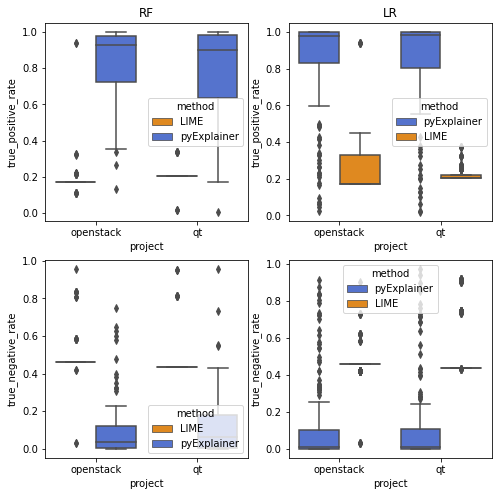

true_positive_rate                      \
                                                count      mean       std   
global_model project   method                                               
LR           openstack LIME                     376.0  0.232394  0.125684   
                       pyExplainer              202.0  0.852543  0.249859   
             qt        LIME                     254.0  0.223436  0.039294   
                       pyExplainer              148.0  0.846509  0.255501   
RF           openstack LIME                     198.0  0.182829  0.080812   
                       pyExplainer              113.0  0.839113  0.187810   
             qt        LIME                      48.0  0.214761  0.070521   
                       pyExplainer               43.0  0.771502  0.275514   

                                                                            \
                                         min       25%       50%       75%   
global_model project   method                                                
LR           openstack LIME         0.172445  0.172445  0.172445  0.326198   
                       pyExplainer  0.023515  0.831776  0.976937  1.000000   
             qt        LIME         0.204461  0.204461  0.204461  0.219972   
                       pyExplainer  0.019741  0.802237  0.983592  1.000000   
RF           openstack LIME         0.110039  0.172445  0.172445  0.172445   
                       pyExplainer  0.133253  0.723847  0.927344  0.979801   
             qt        LIME         0.020254  0.204461  0.204461  0.204461   
                       pyExplainer  0.008845  0.638123  0.898090  0.985386   

                                             true_negative_rate            \
                                         max              count      mean   
global_model project   method                                               
LR           openstack LIME         0.939102              376.0  0.456051   
                       pyExplainer  1.000000              202.0  0.116475   
             qt        LIME         0.371106              254.0  0.514201   
                       pyExplainer  1.000000              148.0  0.127640   
RF           openstack LIME         0.939102              198.0  0.486600   
                       pyExplainer  1.000000              113.0  0.100962   
             qt        LIME         0.335342               48.0  0.532300   
                       pyExplainer  1.000000               43.0  0.147841   

                                                                            \
                                         std       min       25%       50%   
global_model project   method                                                
LR           openstack LIME         0.080481  0.030960  0.459752  0.459752   
                       pyExplainer  0.214088  0.000000  0.000000  0.011610   
             qt        LIME         0.154259  0.430672  0.436975  0.436975   
                       pyExplainer  0.235930  0.000000  0.000000  0.008403   
RF           openstack LIME         0.106922  0.030960  0.459752  0.459752   
                       pyExplainer  0.154585  0.000000  0.006192  0.035604   
             qt        LIME         0.179187  0.436975  0.436975  0.436975   
                       pyExplainer  0.218619  0.000000  0.002101  0.065126   

                                                        
                                         75%       max  
global_model project   method                           
LR           openstack LIME         0.459752  0.899381  
                       pyExplainer  0.103715  0.911765  
             qt        LIME         0.436975  0.918067  
                       pyExplainer  0.105567  0.970588  
RF           openstack LIME         0.459752  0.955108  
                       pyExplainer  0.119195  0.750774  
             qt        LIME         0.436975  0.953782  
                       pyExplainer  0.178571  0.955

In [239]:
show_rq3_eval_result()

In [61]:
## use inverse rule to predict train/test clean instance
def rq3_get_guidance(proj_name, global_model_name):
    global_model_name = global_model_name.upper()
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)

    commit_id_list = '''7b64653931628328bd5d70b0cdea8952e6c709f8
be23b19905a9e500fa4b14c43b9492f4b43e9828
848ef0043f60795db680afe8f67b633459eaf52c
608c67439c8fcfa1a2fddd1087ca1fe998a8f9fd
607acb33be18f0e508329f3c8514061322d294a9
2bfc7171c23d0595aa7f8680271778bc58cb28ba
9bc29208bda6071a34bcc0da36a396eb8bab4f30
10c5c93925abe3d34c4430e0ed852d8358fb2353
d72848c9afba40d21235a4e95cf8e69549290dca
f4b78c7f17e29448ed54b136eeb4ac700b324120
0eb7e35fbfe5de5f9f00ff1a0cce1d6a61f3a902
8e575be75c80ea71a6ad8fb73e6ace1ed708938f
9928edb42da42af3463d4a989a0797be46198908
1724c5cee71d3b32466dd9d6cabd22a3339546b4
874e272a56d314a6fb1bd98e7ecd7f986f3b3898
fc27c5e3df4b047f2da31e6217e36936b331093f
1a40831f1711bf46c878dd247679bb05d19ffb5a
41e3a94ae18a9219ff4ab10389f3a7799c9b6493
b0306a93645ea6475a2bc045d8fc8bc4bd6f00a5
1d6235cc3fb3c7806c2c4671f1c5b03022136008
486e10d3740301b417e2a972ec7c797f562e75be'''.split('\n')
    
#     print(commit_id_list)
    
    py_exp_guidance = pd.DataFrame()
    
    for commit in commit_id_list:
        exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+commit+'.pkl','rb'))
        py_exp = exp_obj['pyExplainer']
        
        py_exp_local_model = py_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
        py_exp_flip_rule = flip_rule(py_exp_the_best_defective_rule_str)
        
        py_exp_guidance = py_exp_guidance.append(pd.Series([proj_name,commit, '', 
                                                            py_exp_the_best_defective_rule_str, py_exp_flip_rule]),
                                                ignore_index=True)
        
    py_exp_guidance.columns = ['system','commitID','repoName','explanation','guidance']
    py_exp_guidance.to_csv('./guidance_table/'+proj_name+'_'+global_model_name+'_pyExplainer_guidance.csv',index=False)
    
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+row_index+'.pkl','rb'))
#         py_exp = exp_obj['pyExplainer']
#         lime_exp = exp_obj['LIME']

#         py_exp_local_model = py_exp['local_model']
#         lime_exp_local_model = lime_exp['local_model']
        
#         py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
        
#         lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

#         py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
#         lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

#         # system(qt/openstack), commitID, repoName, explanation, guidance
        
#         if py_exp_pred:
#             py_exp_flip_rule = flip_rule(py_exp_the_best_defective_rule_str)
#             found_commit_id.append(row_index)
# #             repo_of_commit = commit_repo_dict[row_index]
# #             py_exp_guidance = py_exp_guidance.append(pd.Series([proj_name, row_index, repo_of_commit, 
# #                                                                 py_exp_the_best_defective_rule_str, py_exp_flip_rule]))
# #             break
        
#         if lime_pred:
#             lime_flip_rule = flip_rule(lime_the_best_defective_rule_str)
#             found_commit_id.append(row_index)
#             repo_of_commit = commit_repo_dict[row_index]
#             lime_guidance = lime_guidance.append(pd.Series([proj_name, row_index, repo_of_commit, 
#                                                             lime_the_best_defective_rule_str, lime_flip_rule]))
#             break

#         print('finished {} from {} commits'.format(str(i+1),len(feature_df)))
        
# #         break
        
#     print('finished RQ3 of',proj_name)
    
#     py_exp_guidance.columns = ['system','commitID','repoName','explanation','guidance']
#     lime_guidance.columns = ['system','commitID','repoName','explanation','guidance']
    
#     py_exp_guidance.to_csv('./guidance_table/'+proj_name+'_'+global_model_name+'_pyExplainer_guidance.csv',index=False)
#     lime_guidance.to_csv('./guidance_table/'+proj_name+'_'+global_model_name+'_LIME_guidance.csv',index=False)
    
#     print(len(set(found_commit_id)-set(commit_hash_list)))
#     print(len(commit_hash_list))
    print('finished')
    
#     return set(found_commit_id)

In [62]:
set_rf = rq3_get_guidance('openstack','rf')

finished


In [52]:
set_lr = rq3_get_guidance('openstack','lr')

finished


In [32]:
def get_sample_rules(proj_name, global_model_name):
    global_model_name = global_model_name.upper()
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name, global_model_name)

    commit_id_list = '''608c67439c8fcfa1a2fddd1087ca1fe998a8f9fd
2bfc7171c23d0595aa7f8680271778bc58cb28ba
b0306a93645ea6475a2bc045d8fc8bc4bd6f00a5
10c5c93925abe3d34c4430e0ed852d8358fb2353
7b64653931628328bd5d70b0cdea8952e6c709f8
be23b19905a9e500fa4b14c43b9492f4b43e9828
848ef0043f60795db680afe8f67b633459eaf52c
607acb33be18f0e508329f3c8514061322d294a9
9bc29208bda6071a34bcc0da36a396eb8bab4f30
d72848c9afba40d21235a4e95cf8e69549290dca
f4b78c7f17e29448ed54b136eeb4ac700b324120
0eb7e35fbfe5de5f9f00ff1a0cce1d6a61f3a902
8e575be75c80ea71a6ad8fb73e6ace1ed708938f
9928edb42da42af3463d4a989a0797be46198908
1724c5cee71d3b32466dd9d6cabd22a3339546b4
874e272a56d314a6fb1bd98e7ecd7f986f3b3898
fc27c5e3df4b047f2da31e6217e36936b331093f
1a40831f1711bf46c878dd247679bb05d19ffb5a
41e3a94ae18a9219ff4ab10389f3a7799c9b6493
1d6235cc3fb3c7806c2c4671f1c5b03022136008
486e10d3740301b417e2a972ec7c797f562e75be'''.split('\n')
    
#     print(commit_id_list)
    
    py_exp_guidance = pd.DataFrame()
    
    for commit in commit_id_list:
        exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+commit+'.pkl','rb'))
        py_exp = exp_obj['pyExplainer']
        
        py_exp_local_model = py_exp['local_model']
        
        rule_df = py_exp_local_model.get_rules()
#     print(rule_df)
        top_k = 10
        top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False).head(top_k)
    
        display(top_k_positive_rules)
        display(list(top_k_positive_rules['rule']))
        break
#         py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
#         py_exp_flip_rule = flip_rule(py_exp_the_best_defective_rule_str)
        
#         py_exp_guidance = py_exp_guidance.append(pd.Series([proj_name,commit, '', 
#                                                             py_exp_the_best_defective_rule_str, py_exp_flip_rule]),
#                                                 ignore_index=True)

In [33]:
get_sample_rules('openstack','rf')

,rule,type,coef,support,importance
330,ndev > 127.18500137329102 & ent <= 1.004999995...,rule,0.488276,0.517241,0.243993
828,nrev > 7.184999942779541 & age <= 13.360000133...,rule,0.481389,0.557029,0.239124
754,nd <= 5.610000133514404 & ent > 0.824999988079...,rule,0.570549,0.201592,0.228898
1108,ndev > 114.02499771118164 & asawr <= 0.0349999...,rule,0.482641,0.339523,0.228554
145,la > 117.33499908447266 & ent > 0.335000008344...,rule,0.433971,0.474801,0.216710
1216,rrexp <= 1013.7949829101562,rule,0.512157,0.230769,0.215785
1231,rrexp > 974.0050048828125 & nrev <= 11.6849999...,rule,0.458773,0.328912,0.215540
1804,la > 18.61500072479248 & ndev <= 183.964996337...,rule,0.434740,0.572944,0.215044
60,la <= 51.85500144958496,rule,0.442330,0.270557,0.196504
1277,rrexp <= 1659.5449829101562 & app <= 2.0049999...,rule,0.456837,0.236074,0.194004


['ndev > 127.18500137329102 & ent <= 1.0049999952316284 & la > 8.34000015258789',
 'nrev > 7.184999942779541 & age <= 13.360000133514404 & rrexp > 1159.6649780273438',
 'nd <= 5.610000133514404 & ent > 0.824999988079071 & la > 32.94499969482422',
 'ndev > 114.02499771118164 & asawr <= 0.03499999921768904',
 'la > 117.33499908447266 & ent > 0.33500000834465027',
 'rrexp <= 1013.7949829101562',
 'rrexp > 974.0050048828125 & nrev <= 11.684999942779541 & ndev <= 190.7300033569336',
 'la > 18.61500072479248 & ndev <= 183.96499633789062 & ndev > 113.75',
 'la <= 51.85500144958496',
 'rrexp <= 1659.5449829101562 & app <= 2.0049999952316284 & ndev <= 168.15499877929688']

# Test pyExplainer visualization

In [10]:
proj_name = 'openstack'
global_model_name = 'RF'

x_train, y_train = prepare_data(proj_name, mode = 'train')
global_model = pickle.load(open(proj_name+'_'+global_model_name+'_global_model.pkl','rb'))
indep = x_test.columns
dep = 'defect'
class_label = ['clean', 'defect']

pyExp = PyExplainer(x_train, y_train, indep, dep, global_model, class_label)

In [11]:
exp_obj = pickle.load(open(pyExp_dir+proj_name+'_'+global_model_name+'_all_explainer_'+'34a208d1f3829173815beca81d07b53633a12989'+'.pkl','rb'))

In [12]:
# pyExp.visualise(exp_obj)
# print(exp_obj['pyExplainer'].keys())
pyexp_obj = exp_obj['pyExplainer']

In [15]:
pyExp.visualise(pyexp_obj)

Output(layout=Layout(border='3px solid black'))